In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import difflib
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import re
from collections import Counter
from datetime import datetime
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from scipy.sparse import hstack, csr_matrix

from surprise import Dataset, Reader, SVDpp, SVD, accuracy, NormalPredictor
from surprise.model_selection import train_test_split as sp_train_test_split

np.random.seed(3742)

# Movie Recommendation System


## Introduction
Entertainment is a vital component of human culture, with films influencing societal trends and providing a source of enjoyment for people around the globe. The overwhelming volume of movies available today makes it challenging for people to discover content that aligns with their unique tastes. Early and accurate identification of user preferences is key to enhancing their viewing experience. In recent years, advancements in data analytics and machine learning have created new ways for personalizing content delivery in the film industry. Among these, movie recommendation systems stand out as a comprehensive method for guiding viewers through finding their new favourite movie.


## Dataset Overview

Let's look at the two data sources that we will be using for our recommendation system and explain what they will contain.

1. [MovieLens 32M Dataset](https://grouplens.org/datasets/movielens/32m/)

This dataset comprises four interconnected components:

	•	Ratings: Contains users’ ratings for specific movies
	•	Movies: Includes movie titles and genres.
	•	Links: Provides identifiers like IMDb and TMDb IDs, enabling us to merge data across different sources.
	•	Tags: Captures user-assigned tags to movies

2. [The Ultimate 1 Million Movies Dataset (TMDb + IMDb)](https://www.kaggle.com/datasets/alanvourch/tmdb-movies-daily-updates?resource=download)

This dataset offers comprehensive metadata for one million movies, sourced from TMDb and supplemented with IMDb ratings. It includes details such as:

	•	Movie Metadata: Information on cast, crew, production companies, release dates, runtime, budget, revenue, and more.

By integrating these datasets, we can effectively apply standard machine learning algorithms to build a robust movie recommendation system. 

## 1.Data Gathering

In [2]:
pd.reset_option('all')

/var/folders/6f/pgdvkqt91lq31wb_lcq5cwr80000gn/T/ipykernel_20969/2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/var/folders/6f/pgdvkqt91lq31wb_lcq5cwr80000gn/T/ipykernel_20969/2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


In [3]:
movie_ratings = pd.read_csv("data/ratings.csv")

In [4]:
movie_links = pd.read_csv("data/links.csv")

In [5]:
movie_tags = pd.read_csv("data/tags.csv")

In [6]:
movies_genres = pd.read_csv("data/movies.csv")

In [7]:
movies_tmdb = pd.read_csv("data/TMDB_all_movies.csv")

Ok now let's explore every one of these datasets so we know what we are working with.

In [8]:
movie_ratings.sample(10)

,userId,movieId,rating,timestamp
3273298,20583,3481,4.0,1674108142
1833659,11642,40732,3.5,1690499709
3344129,21005,4886,4.0,1200479018
27941682,175238,1350,3.0,1130187070
339262,2212,2949,4.0,1136071002
374089,2465,40732,2.5,1495416152
27418119,172018,51255,2.5,1545080141
21927434,137221,7090,5.0,1287745620
29859378,187257,2174,2.5,1441955821
24889346,156202,1645,2.5,1162774364


In [9]:
movie_ratings.shape

(32000204, 4)

In [10]:
movie_ratings.columns = ["user_id","movie_id","rating","timestamp"]

The first dataset contains over 30 million user ratings, including user_id, movie_id, rating, and a timestamp representing the number of seconds since midnight UTC on January 1, 1970.

In [11]:
movie_links.sample(10)

,movieId,imdbId,tmdbId
47847,174281,1705951,194040.0
76650,253754,3564860,381325.0
72917,236663,29070,471604.0
19764,102596,1407927,39333.0
21026,108679,38319,250117.0
74052,241646,9642950,577314.0
86079,287465,156142,464989.0
44567,167454,4690134,369875.0
57185,194078,193535,292054.0
81667,274469,9572006,576925.0


In [12]:
movie_links.columns = ["movie_id","imdb_id","tmdb_id"]

In [13]:
movie_links.shape

(87585, 3)

Here we have a dataset with the IDs of the movies used in MovieLens, the IDs in IMDb, and in TMDb. We will use this table later to merge our datasets into one.

In [14]:
movie_tags.sample(10)

,userId,movieId,tag,timestamp
947168,78213,52189,friendship,1527373395
1678764,123480,8907,accidental death,1620341582
1608414,117832,203375,Matt Damon,1591989936
165361,23933,285851,based on a true story,1686518334
1759959,136346,206107,gritty,1606984478
1840607,146849,149406,cheesy ending,1532610269
1658309,121484,97938,cinematography,1511449237
576422,76037,74754,Tommy Wiseau,1517086093
1082257,78213,112290,separated parents,1612505954
613873,78213,353,troubled production,1629094998


In [15]:
movie_tags = movie_tags.rename(columns={'userId': 'user_id',
                                        'movieId': 'movie_id'})
movie_tags.shape

(2000072, 4)

This dataset contains 20 million observations of users placing tags on movies. The timestamp is in the same format as one of the datasets above.

In [16]:
movies_genres.sample(10)

,movieId,title,genres
34424,144776,"Alfie, the Little Werewolf (2011)",Children
78157,261083,Dune World (2021),Sci-Fi
22671,115929,Barbie: A Perfect Christmas (2011),Animation|Children
83581,279998,Jonathan (1970),Drama|Horror
11547,52589,"Resurrected, The (1992)",Horror
1285,1319,Kids of Survival (1996),Documentary
81015,272089,Medium (1985),Horror
43715,165581,Operation Mekong (2016),Action|Thriller
19310,100344,No (2012),Drama
43590,165327,O Shaolin do Sertão (2016),Comedy


In [17]:
movies_genres = movies_genres.rename(columns ={"movieId": "movie_id"})
movies_genres.shape

(87585, 3)

Here we have the genres for all of the movies from the first data source.

In [18]:
movies_tmdb.sample(10)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
732943,1031394,"Merry Christmas, Svensson Svensson",0.000,0.0,Released,1994-12-23,0.0,26.0,0.0,tt22474284,...,svenska,"Allan Svensson, Chelsie Bell Dickson, Gösta Kr...",Mikael Ekman,NaN,"Tomas Tivemark, Johan Kindblom, Michael Hjorth",Pia Ehrnvall,NaN,9.1,53.0,/s8o0W8B48PreZKhuZDGOMDBpJRf.jpg
148102,257684,Calamity Jane,7.000,1.0,Released,1984-03-06,0.0,100.0,0.0,tt0087021,...,English,"Jessica Nelson, Isabell O'Connor, Henry Kendri...",James Goldstone,Terry K. Meade,Suzanne Clauser,"Jane Alexander, Bernard Sofronski, Herbert Hir...",NaN,6.4,174.0,/p8IkWaJBnu1vrkfGFpVZkU8WWU6.jpg
548160,768708,"I, Robot",0.000,0.0,Released,2019-09-13,0.0,4.0,0.0,tt12882180,...,Український,NaN,Roman Bordun,NaN,NaN,NaN,NaN,6.3,7.0,/nidMPdkYwRjwio7DVIXicnsmlgi.jpg
882157,1231450,Doctor Who: The Eternal Mystery,0.000,0.0,Released,2022-01-20,0.0,8.0,0.0,NaN,...,English,"Leo Flanagan, Nicola Bryant",Pete McTighe,NaN,Pete McTighe,NaN,NaN,NaN,NaN,/7B1uZPR58CoNf5WhQtLPa3dVgd8.jpg
5610,10532,Abbuzze! Der Badesalz-Film,6.625,28.0,Released,1996-01-17,0.0,95.0,0.0,tt0115448,...,Deutsch,"Eva Ebner, Christiane Reiff, Gerd Knebel, Henn...",Roland Willaert,Roland Willaert,"Gerd Knebel, Henni Nachtsheim",Reinhard Klooss,"Mimi Poulakis, Gerd Knebel, Henni Nachtsheim",6.5,946.0,/7xTcp6WJYMN8UlA6bXc87R3QGae.jpg
757146,1065943,Ghost Hand Legend,0.000,0.0,Released,2018-04-22,0.0,105.0,0.0,NaN,...,普通话,"Yang Xiangyu, Chen Xuming, Liu Xiyuan, Lu Guan...",Li Lianjun,NaN,NaN,NaN,NaN,NaN,NaN,/pDw2oI5wLBDMeswZfgcLS38UJRI.jpg
545931,765679,Burning Man: A Whale in the Desert,0.000,0.0,Released,2019-06-30,0.0,52.0,0.0,NaN,...,English,NaN,Scott Schneider,NaN,NaN,NaN,NaN,NaN,NaN,/tx6SoRYYy1CkSGcsa8jrOMz7noM.jpg
233978,359070,Hallway,1.000,1.0,Released,2015-03-15,0.0,4.0,0.0,tt4522158,...,English,"Margaret Singer, Sarah Ellen Stephens",Leah Shore,NaN,Leah Shore,NaN,NaN,4.9,26.0,NaN
870876,1217725,Original title: Murder Girl. A true story,0.000,0.0,Released,2020-08-28,0.0,0.0,0.0,tt12945846,...,Pусский,Ekaterina Dar,Diana Galimzyanova,NaN,NaN,NaN,NaN,9.3,9.0,/5oKHIMWj02MCXynuhStgR4XcclY.jpg
892155,1243371,Des cochons et des hommes,0.000,0.0,Released,2004-04-17,0.0,0.0,0.0,tt0495587,...,Français,"Victor Raynal, Vincent Raynal, Arthur Raynal, ...",Bruno Thomé,NaN,Bruno Thomé,NaN,NaN,NaN,NaN,NaN


In [19]:
movies_tmdb.shape

(1014981, 28)

We are currently looking at the second data source, which contains all the metadata for over 1 million movies. The first dataset includes only about 80 thousand movies, so we will need to drop many of the movies from the second dataset later on.

## 2.Data Cleansing

Removing the duplicates.

In [20]:
movies_tmdb = movies_tmdb.drop_duplicates()
movie_links = movie_links.drop_duplicates()
movie_ratings = movie_ratings.drop_duplicates()
movies_genres = movies_genres.drop_duplicates()
movie_tags = movie_tags.drop_duplicates()

Firstly, let’s remove all the movies that we won’t use from the TMDB dataset (the movies that are missing from the first data source).

We will do this by using the IMDb IDs from the MovieLens dataset and removing the movies in the TMDb dataset that don’t match them.

In [21]:
movie_links.dtypes

movie_id      int64
imdb_id       int64
tmdb_id     float64
dtype: object

In [22]:
movies_tmdb.dtypes

id                           int64
title                       object
vote_average               float64
vote_count                 float64
status                      object
release_date                object
revenue                    float64
runtime                    float64
budget                     float64
imdb_id                     object
original_language           object
original_title              object
overview                    object
popularity                 float64
tagline                     object
genres                      object
production_companies        object
production_countries        object
spoken_languages            object
cast                        object
director                    object
director_of_photography     object
writers                     object
producers                   object
music_composer              object
imdb_rating                float64
imdb_votes                 float64
poster_path                 object
dtype: object

The imdb_id in the TMDB dataset is of type object, and we need to convert it to int to ensure consistency in data types.

In [23]:
movies_tmdb.imdb_id.value_counts(dropna = False)

imdb_id
NaN           425274
tt32094375        38
tt26900526        10
tt26598133         7
tt27430909         7
               ...  
tt0127611          1
tt3203154          1
tt4819514          1
tt3120512          1
tt32486306         1
Name: count, Length: 589091, dtype: int64

There are over 400k observations with NaN values for imdb_id we can directly drop them.

In [24]:
movies_tmdb = movies_tmdb.dropna(subset=['imdb_id'])

Now, let’s remove the “tt” prefix from each ID so that we can convert all the IDs to integers.

In [25]:
movies_tmdb.imdb_id = movies_tmdb.imdb_id.str.replace("tt","",regex=False)
movies_tmdb.imdb_id = movies_tmdb.imdb_id.astype("int")
movies_tmdb.imdb_id.dtypes,movie_links.imdb_id.dtypes

(dtype('int64'), dtype('int64'))

In [26]:
movie_links.imdb_id.value_counts()

imdb_id
114709      1
2089674     1
39758       1
8097306     1
7162400     1
           ..
2350852     1
2232578     1
3699674     1
74855       1
28995566    1
Name: count, Length: 87585, dtype: int64

Now, let’s extract only the movies we need.

In [27]:
movielens_ids = movie_links.imdb_id.values
movielens_ids

array([  114709,   113497,   113228, ..., 12388280,    64027, 28995566])

In [28]:
movies_tmdb = movies_tmdb[movies_tmdb.imdb_id.isin(movielens_ids)]
movies_tmdb.shape

(86856, 28)

The TMDB dataset is currently missing approximately 700 movies from the MovieLens dataset.

In [29]:
movies_tmdb.imdb_id.value_counts()

imdb_id
27430909    7
3367188     4
2061818     4
4818314     4
3892384     4
           ..
57423       1
112782      1
116039      1
127759      1
159931      1
Name: count, Length: 86798, dtype: int64

There are IDs that have more than one appearance in the data, but every movie should have a unique ID. Let’s investigate all the IDs with more than one count.

In [30]:
all_indices_count = movies_tmdb.imdb_id.value_counts(dropna=False)
repeated_indices = list(all_indices_count[all_indices_count > 1].index)
len(repeated_indices)

41

In [31]:
movies_with_same_id = movies_tmdb[movies_tmdb.imdb_id.isin(repeated_indices)]
movies_with_same_id_sorted = movies_with_same_id.sort_values(by="imdb_id")
movies_with_same_id

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
8216,13989,24: Redemption,7.0,429.0,Released,2008-11-23,0.0,102.0,0.0,813980,...,English,"Jon Voight, Mark Kiely, Carly Pope, Tshamano S...",Jon Cassar,NaN,"Robert Cochran, Joel Surnow",Kiefer Sutherland,NaN,7.4,29204.0,NaN
10818,17976,濒于崩溃,6.8,17.0,Released,1962-08-04,0.0,37.0,0.0,217055,...,English,"Marilyn Monroe, John McGiver, Robert Christoph...",George Cukor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48421,69239,Prosta historia o miłości,0.0,0.0,Released,2010-11-19,0.0,0.0,0.0,1776283,...,Polski,"Henryk Gołębiewski, Magdalena Popławska, Rafał...",Arkadiusz Jakubik,Mirosław Jakubik,Maciej Sobieszczański,"Arkadiusz Jakubik, Wiesław Łysakowski",Jarosław Wójcik,6.0,81.0,/sXLe5tbvPRerxBLGZg11iDsSBzH.jpg
132405,231064,Washing Day in Switzerland,5.2,10.0,Released,1896-05-10,0.0,1.0,0.0,222140,...,No Language,NaN,Alexandre Promio,NaN,NaN,"Auguste Lumière, Louis Lumière",NaN,5.1,219.0,NaN
181847,297493,Mystery of the Carpathian Sphinx,0.0,0.0,Released,2013-10-28,0.0,0.0,0.0,4624308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8,46.0,/lxutAgzYE9XzasP3WeJBPz5lauC.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004046,1372740,Our RoboCop Remake,0.0,0.0,Released,2014-02-06,0.0,108.0,0.0,3528906,...,English,"Hank Friedmann, Nichole Bagby, Trevor Moore, D...",NaN,NaN,NaN,NaN,NaN,6.4,519.0,/nYhXrQVnEoG3TWDeoq0YIwq6E1c.jpg
1010513,1380087,Rudge-Whitworth – Britain’s Best Bicycle,0.0,0.0,Released,NaN,0.0,1.0,0.0,345877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,40.0,NaN
1010535,1380110,Space Cop,0.0,0.0,Released,2016-01-12,0.0,102.0,0.0,3892384,...,English,"Rick Pendzich, Mike Stoklasa, Jocelyn Ridgely,...","Mike Stoklasa, Jay Bauman",NaN,"Jay Bauman, Rich Evans, Mike Stoklasa",NaN,NaN,5.2,3792.0,/ggHHp3PHnrr7O4C5a6bbaIoDgYc.jpg
1010574,1380150,Louis C.K. at the Dolby,0.0,0.0,Released,2023-04-04,0.0,0.0,0.0,27430909,...,English,Louis C.K.,Louis C.K.,NaN,Louis C.K.,NaN,NaN,7.7,1528.0,/8g5f9IKoUzwY8BuVzz9kD5RypBo.jpg


We have two options: we can either remove all of these movies because almost all information about them is missing, or we can keep only those with a poster_path that is not NaN, as this indicates that these movies are still available on TMDB and can be accessed.

In [32]:
movies_with_same_id[~movies_with_same_id.poster_path.isna()]

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
48421,69239,Prosta historia o miłości,0.0,0.0,Released,2010-11-19,0.0,0.0,0.0,1776283,...,Polski,"Henryk Gołębiewski, Magdalena Popławska, Rafał...",Arkadiusz Jakubik,Mirosław Jakubik,Maciej Sobieszczański,"Arkadiusz Jakubik, Wiesław Łysakowski",Jarosław Wójcik,6.0,81.0,/sXLe5tbvPRerxBLGZg11iDsSBzH.jpg
181847,297493,Mystery of the Carpathian Sphinx,0.0,0.0,Released,2013-10-28,0.0,0.0,0.0,4624308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8,46.0,/lxutAgzYE9XzasP3WeJBPz5lauC.jpg
564316,789791,Rubber Johnny,7.7,3.0,Released,2017-08-08,0.0,3.0,0.0,441787,...,NaN,NaN,Suki Singh,NaN,NaN,NaN,NaN,7.3,3125.0,/coHW2eVuHLu4JwWA1gMy8ypUUam.jpg
910582,1264525,42 One Dream Rush,0.0,0.0,Released,2010-09-15,0.0,42.0,0.0,2073510,...,English,"Chloë Sevigny, Tadanobu Asano, Helena Christen...","Yung Chang, Larry Clark, Gaspar Noé, Mote Sina...",NaN,"Illya Rozhdestvesnky, Michele Civetta, Rajan M...","David Komurek, Michele Civetta, Samantha Storr...",NaN,5.8,549.0,/tu6uaX7GbVepsVHuuK1Nm2Mrs8W.jpg
921779,1277094,Adolf Hitler: The Greatest Story Never Told!,10.0,1.0,Released,2013-01-27,0.0,350.0,0.0,3526810,...,"Deutsch, English",Adolf Hitler,Dennis Wise,NaN,NaN,Dennis Wise,NaN,7.3,6394.0,/1iKHLfkXYHlRLXxKcYdR33IeAWd.jpg
935178,1292321,Star Trek: Of Gods and Men,4.3,3.0,Released,2007-12-22,0.0,89.0,0.0,835378,...,NaN,"Tim Russ, Grace Lee Whitney, J.G. Hertzler, Ch...",Tim Russ,NaN,NaN,NaN,NaN,6.1,1512.0,/yXbjedLP5zULeezfNdRrNyZCn8a.jpg
943270,1301768,At the Suicide of the Last Jew in the World in...,0.0,0.0,Released,2007-05-20,0.0,4.0,0.0,14148306,...,English,David Cronenberg,David Cronenberg,NaN,David Cronenberg,NaN,NaN,6.1,159.0,/4dj6GoUW46AcG1tdRbtjiq3CT2L.jpg
946483,1305327,Hellstorm,0.0,0.0,Released,2015-05-01,0.0,90.0,3500.0,4661358,...,English,"John Alan Martinson, Andrew MacCrinnan, Paul H...",Kyle Hunt,NaN,"Kyle Hunt, Thomas Goodrich",NaN,NaN,6.7,2999.0,/22bjNz5GruDvGM5YcaSdNyAgSnb.jpg
955260,1315180,World Cinema,0.0,0.0,Released,2007-05-20,0.0,0.0,0.0,5747464,...,NaN,"Brooke Smith, Grant Heslov, Josh Brolin","Joel Coen, Ethan Coen",NaN,"Joel Coen, Ethan Coen",NaN,NaN,6.6,406.0,/yfo3X2ZknQzcc5DBsTx1QMnXUR0.jpg
957311,1317450,Back to the Future... The Ride,7.0,1.0,Released,1991-05-02,0.0,0.0,0.0,101392,...,English,"Christopher Lloyd, Thomas F. Wilson","Les Mayfield, Douglas Trumbull",NaN,NaN,NaN,NaN,7.9,2210.0,/5BqWX11F4JnpxUv5oOfZ7gL6IEM.jpg


There are still some repeating IDs and a lot of missing information, so we will remove all the movies with repeating IDs, which amount to just 30.

In [33]:
movies_tmdb = movies_tmdb[~movies_tmdb.imdb_id.isin(repeated_indices)]

In [34]:
movies_tmdb.shape

(86757, 28)

In [35]:
movie_links = movie_links[~movie_links.imdb_id.isin(repeated_indices)]

In [36]:
movie_links

,movie_id,imdb_id,tmdb_id
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
87580,292731,26812510,1032473.0
87581,292737,14907358,986674.0
87582,292753,12388280,948139.0
87583,292755,64027,182776.0


We now see that movie_links have more movies so we need to remove the ones missing in the TMDB datset.

In [37]:
indices = movies_tmdb.imdb_id.values
movie_links = movie_links[movie_links.imdb_id.isin(indices)]
movie_links.shape

(86757, 3)

Let's remove the movies with 0 vote average because we don't have rating for them and a lot of the other metadata for them is missing.

In [38]:
movies_tmdb[movies_tmdb.vote_average == 0]

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
1972,3015,The Head of Janus,0.0,0.0,Released,1920-08-26,0.0,107.0,0.0,11348,...,Deutsch,"Jaro Fürth, Bela Lugosi, Magnus Stifter, Willy...",F. W. Murnau,"Carl Weiss, Carl Hoffmann, Karl Freund","Robert Louis Stevenson, Hans Janowitz",Erich Pommer,NaN,7.3,174.0,/QomFFEz7FN5plcSmEhAGT2OdGL.jpg
3137,5660,Mystery Mansion,0.0,0.0,Released,1984-07-02,0.0,95.0,0.0,91587,...,English,"David Wagner, Randi Brown, Barry Hostetler, Ri...",David Jackson,NaN,"Jack Duggan, David Jackson, Arn Wihtol",Arthur R. Dubs,William Loose,4.5,153.0,/yxxPZH9076wgsqdv6ZLBqsHfb2O.jpg
3138,5661,Where's Willie?,0.0,0.0,Released,1978-04-12,0.0,97.0,0.0,78487,...,English,"Henry Darrow, John Mitchum, Katherine Woodvill...",John Florea,Robert Caramico,"Frank Koomen, Alan Cassidy, Ann Koomen","Ken Pratt, Will Whittle",NaN,5.6,80.0,/pXSIIgbGBr2W7FCeVRFSNrfUdJd.jpg
3296,5911,Zwischen Schanghai und St. Pauli,0.0,0.0,Released,1962-10-05,0.0,86.0,0.0,56728,...,Deutsch,"Karin Baal, Mario del Marius, Joachim Hansen, ...","Wolfgang Schleif, Roberto Bianchi Montero",Klaus von Rautenfeld,J. Joachim Bartsch,Wolf C. Hartwig,Raimund Rosenberger,5.7,34.0,NaN
3542,6441,Till the End of the Night,0.0,0.0,Released,1995-05-09,0.0,90.0,0.0,111431,...,English,"Katherine Kelly Lang, Roger Clinton, Jr., Davi...",Larry Brand,Bernard Salzmann,Larry Brand,"Steven Stabler, Brad Krevoy",Mark Governor,3.8,481.0,/o8r1QlSAvEWgHEAEeEy2iOAHBqW.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005172,1374050,维多利亚的秘密时装秀2017,0.0,0.0,Released,2017-11-28,0.0,42.0,0.0,7624712,...,NaN,"Candice Swanepoel, Elsa Hosk, Liu Wen, Lily Al...",Ben Hall,NaN,NaN,NaN,NaN,6.6,175.0,/oioYd0QjrbOF1JB56wRk9WwDW89.jpg
1005726,1374666,The Victorias Secret Fashion Show 2013,0.0,0.0,Released,2013-12-10,0.0,0.0,0.0,3396128,...,NaN,"Cara Delevingne, Lindsay Ellingson, Andy Hurle...",Hamish Hamilton,NaN,NaN,NaN,NaN,7.8,363.0,/rPAfdslUdJ1kRFtUNIUe9VebIRc.jpg
1006226,1375219,The Necessary War,0.0,0.0,Released,2014-02-25,0.0,60.0,0.0,3564534,...,English,Max Hastings,Karen McGann,NaN,Max Hastings,"Denys Blakeway, Karen McGann",NaN,6.2,40.0,/aMZIgVJe0Rh9yU0f4fn5r1hgxQN.jpg
1006627,1375649,Victoria's Secret Fashion Show,0.0,0.0,Released,NaN,0.0,0.0,0.0,300611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8,211.0,NaN


In [39]:
movies_tmdb = movies_tmdb[~(movies_tmdb.vote_average == 0)]
movies_tmdb = movies_tmdb[~(movies_tmdb.vote_count == 0)]
movies_tmdb = movies_tmdb[~(movies_tmdb.imdb_rating == 0)]
movies_tmdb = movies_tmdb[~(movies_tmdb.imdb_votes == 0)]

We should review the current columns in the TMDB dataset and remove those that are not needed for our recommendation system.

In [40]:
movies_tmdb.dtypes

id                           int64
title                       object
vote_average               float64
vote_count                 float64
status                      object
release_date                object
revenue                    float64
runtime                    float64
budget                     float64
imdb_id                      int64
original_language           object
original_title              object
overview                    object
popularity                 float64
tagline                     object
genres                      object
production_companies        object
production_countries        object
spoken_languages            object
cast                        object
director                    object
director_of_photography     object
writers                     object
producers                   object
music_composer              object
imdb_rating                float64
imdb_votes                 float64
poster_path                 object
dtype: object

First we will remove the id,the poster path, the status and the overview because we won't need this data for our recomendation system. Then we will remove the following fields for too much missing values - Music Composer, Revenue, Budget, Director of Photography and Producers and Production Companies.

In [41]:
print(len(movies_tmdb[movies_tmdb.music_composer.isna()]),len(movies_tmdb[movies_tmdb.revenue == 0]), 
      len(movies_tmdb[movies_tmdb.director_of_photography.isna()]),
      len(movies_tmdb[movies_tmdb.producers.isna()]),len(movies_tmdb[movies_tmdb.budget == 0]))

45444 69884 27657 20761 69268


In [42]:
movies_tmdb = movies_tmdb.drop(columns = ["poster_path","id","revenue","music_composer","status",
                                          "tagline","producers","director_of_photography","original_title","budget"])
movies_tmdb = movies_tmdb[~movies_tmdb.overview.isna()]

In [43]:
movies_tmdb.shape,movie_links.shape

((84040, 18), (86757, 3))

In [44]:
len(movies_tmdb[movies_tmdb.cast.isna()])

3022

Cast is a really important feature because many people watch certain movies due to the cast they like. Therefore, we will remove all movies with a missing cast, as there is not a lot of missing data.

In [45]:
movies_tmdb = movies_tmdb[~movies_tmdb.cast.isna()]

In [46]:
len(movies_tmdb[movies_tmdb.spoken_languages.isna()])

2791

Spoken languages are also an important feature because we can’t recommend movies to someone who won’t understand them. For now, we are going to remove the movies with missing values, but later, we might decide to remove this feature and keep only the original language if there is really high cardinality.

In [47]:
movies_tmdb = movies_tmdb[~movies_tmdb.spoken_languages.isna()]

In [48]:
movies_tmdb[movies_tmdb.director.isna()].shape

(230, 18)

There are 200 movies with a missing director. We will remove these movies as well and use the same approach to decide whether to keep or remove other features if there is no high cardinality.

In [49]:
movies_tmdb = movies_tmdb[~movies_tmdb.director.isna()]

Now we are going to remove all the movies which we removed from our TMDB dataset, from the MovieLens datasets.

In [50]:
ids = movies_tmdb["imdb_id"].values
movie_links = movie_links[movie_links.imdb_id.isin(ids)]
movielens_ids = movie_links["movie_id"].values
movies_genres = movies_genres[movies_genres.movie_id.isin(movielens_ids)]

In [51]:
movie_links.shape,movies_genres.shape, movies_tmdb.shape

((77997, 3), (77997, 3), (77997, 18))

Let's look into the movies which have missing genre values. 

In [52]:
movies_genres.genres.value_counts(dropna = False)

genres
Drama                                          11654
Comedy                                          7105
Documentary                                     5442
(no genres listed)                              4936
Comedy|Drama                                    3076
                                               ...  
Action|Comedy|Musical|Sci-Fi                       1
Action|Comedy|Film-Noir|Musical|Sci-Fi             1
Adventure|Animation|Comedy|Fantasy|IMAX            1
Action|Animation|Mystery|IMAX                      1
Animation|Comedy|Crime|Drama|Romance|Sci-Fi        1
Name: count, Length: 1761, dtype: int64

In [53]:
movies_tmdb.genres.value_counts(dropna = False)

genres
Drama                                         8856
Comedy                                        5963
Documentary                                   4424
Drama, Romance                                2399
Comedy, Drama                                 2120
                                              ... 
Animation, Drama, Horror, Romance                1
Action, Thriller, Horror, TV Movie               1
Action, Western, Music, Comedy                   1
Mystery, Adventure, Action, Drama, History       1
Comedy, Music, Drama, Science Fiction            1
Name: count, Length: 6279, dtype: int64

In the MovieLens genres dataset, there are 5,000 movies with missing genres. By looking at the value counts, we can’t determine if there are any missing genres in the TMDB dataset, so let’s explicitly check for NaN values.

In [54]:
movies_genres[movies_genres.genres.isna()].shape, movies_tmdb[movies_tmdb.genres.isna()].shape

((0, 3), (382, 18))

In the TMDB dataset, there are around 400 movies with missing genres. We can use the TMDB dataset genres to check if some of these missing 400 movies are present in the MovieLens dataset and fill in the missing values accordingly.

In [55]:
ids_movies_missing_genres = movies_tmdb[movies_tmdb.genres.isna()]["imdb_id"].values
movielens_ids_missing_genres = movie_links[movie_links.imdb_id.isin(ids_movies_missing_genres)].movie_id.values
movies_genres[movies_genres.movie_id.isin(movielens_ids_missing_genres)].genres.value_counts()

genres
(no genres listed)        328
Drama                      13
Documentary                12
Comedy                      9
Drama|Romance               4
Comedy|Drama|Romance        2
Crime|Drama                 2
Drama|Fantasy|Romance       1
Documentary|Drama           1
Children|Comedy|Drama       1
Crime|Drama|Thriller        1
Musical                     1
Comedy|Romance              1
Comedy|Romance|War          1
Adventure|Documentary       1
Comedy|Horror|Thriller      1
Horror|Thriller             1
Thriller                    1
Mystery                     1
Name: count, dtype: int64

Almost all of the movies with missing genres in the TMDB dataset also have missing genres in the MovieLens dataset. We can add the genres for the 50 movies with non-missing values to the TMDB dataset. As for the first 345 movies, we can remove them from both datasets since they won’t be used.

In [56]:
movies_to_remove_ids = movies_genres[((movies_genres.movie_id.isin(movielens_ids_missing_genres)) & (movies_genres.genres == "(no genres listed)"))]["movie_id"].values
movies_genres = movies_genres[~((movies_genres.movie_id.isin(movielens_ids_missing_genres)) & (movies_genres.genres == "(no genres listed)"))]
imdb_ids_remove = movie_links[movie_links.movie_id.isin(movies_to_remove_ids)]["imdb_id"].values
movie_links = movie_links[~movie_links.movie_id.isin(movies_to_remove_ids)]
movies_tmdb = movies_tmdb[~movies_tmdb.imdb_id.isin(imdb_ids_remove)]
movie_links.shape,movies_tmdb.shape

((77669, 3), (77669, 18))

Let’s extract the genres from the MovieLens dataset to the TMDB dataset. After that, we can disregard the MovieLens genres dataset, as we won’t need it anymore. First, we will get the IDs of the movies for which we need to retrieve the genres, and then we will change the MovieLens genre column separator from “|” to “, “.

In [57]:
merged_links_genres = pd.merge(movies_genres[movies_genres.movie_id.isin(movielens_ids_missing_genres)], movie_links[['movie_id','imdb_id']], on='movie_id')
merged_links_genres.genres = merged_links_genres.genres.str.replace("|",", ")
imdb_to_genres = dict(zip(merged_links_genres.imdb_id.values, merged_links_genres.genres.values))
movies_tmdb['genres'] = movies_tmdb['genres'].combine_first(movies_tmdb['imdb_id'].map(imdb_to_genres))

In [58]:
movies_tmdb.shape,movies_tmdb[movies_tmdb.genres.isna()].shape

((77669, 18), (0, 18))

Great! There are no longer any missing values in the genres column for the movies we currently have. 
Earlier, we noticed that the release_date column is of type object. We will now convert it to datetime for easier operations with this column. Let’s also check if there are any movies with missing release_date values.

In [59]:
movies_tmdb[movies_tmdb.release_date.isna()].shape

(1, 18)

There is only one movie with missing release date we can remove it.


In [60]:
movies_tmdb = movies_tmdb[~movies_tmdb.release_date.isna()]
movies_tmdb.release_date = pd.to_datetime(movies_tmdb['release_date'])

In [61]:
movies_tmdb.dtypes

title                           object
vote_average                   float64
vote_count                     float64
release_date            datetime64[ns]
runtime                        float64
imdb_id                          int64
original_language               object
overview                        object
popularity                     float64
genres                          object
production_companies            object
production_countries            object
spoken_languages                object
cast                            object
director                        object
writers                         object
imdb_rating                    float64
imdb_votes                     float64
dtype: object

Let's take a look into the writers colum.

In [62]:
movies_tmdb[movies_tmdb.writers.isna()].shape

(5511, 18)

There are over 5,000 movies with missing writers. We have two options: either remove the entire column or remove these 5,000 movies. In this case, we can assume that the writers feature is important for recommending a movie, as many people care about the writers. Therefore, we will remove all 5,000 movies with missing values in this column.

In [63]:
movies_tmdb =  movies_tmdb[~movies_tmdb.writers.isna()]
movies_tmdb.shape

(72157, 18)

In [64]:
movies_tmdb[movies_tmdb.production_countries.isna()].shape,movies_tmdb[movies_tmdb.imdb_rating.isna()].shape

((2257, 18), (35, 18))

There are 2000 movies with missing production countries. We have to decide if we will remove the movies with NaN values for production countries or just remove the whole column. Let’s look at the Production Countries. Also, there are 20 movies with missing IMDb ratings we can just remove them too.

In [65]:
movies_tmdb.production_countries.value_counts()

production_countries
United States of America                                 28209
United Kingdom                                            3696
Japan                                                     2651
France                                                    2605
Italy                                                     2118
                                                         ...  
France, Hong Kong, Japan                                     1
United Kingdom, Argentina                                    1
Spain, Germany, Italy, Iran, United States of America        1
Brazil, Chile, Argentina, Spain                              1
United States of America, Taiwan                             1
Name: count, Length: 3884, dtype: int64

In [66]:
print(f"Amount of observations with unique combination of countries < 10 - {(movies_tmdb.production_countries.value_counts().values<10).sum()}")

Amount of observations with unique combination of countries < 10 - 3662


There are over 3,700 different combinations of countries, which is a lot compared to the 70,000 movies we have, and only 118 of them contain a single country. One option is to extract the most popular country from the movies with multiple countries. However, many countries would still have a low count of movies. A better option would be to remove this entire column, as it might cause overfitting due to the low number of movies associated with some countries.


In [67]:
movies_tmdb = movies_tmdb.drop(columns = (["production_countries"]))
movies_tmdb = movies_tmdb[~movies_tmdb.imdb_rating.isna()]

In [68]:
movies_tmdb.shape

(72122, 17)

Let's also remove the movies that have a really low vote count. For example in TMBD movies with vote count below 5 and imdb vote count below 50. 

In [69]:
movies_tmdb[~((movies_tmdb.vote_count<5) | (movies_tmdb.imdb_votes<50))].shape

(65349, 17)

We are going to remove over 7500 movies, because they don't bring us a lot information due to the their low amount of ratings. It is crucial for us to remove those movies, because their ratings might be biased, they might cause our model to overfit somewhere later on.

In [70]:
movies_tmdb = movies_tmdb[~((movies_tmdb.vote_count<5) | (movies_tmdb.imdb_votes<50))]

Now let's see if there are any missing values for the runtime of a movie.

In [71]:
movies_tmdb[movies_tmdb.runtime == 0].shape

(178, 17)

There are 350 with runtime equal to 0. Let's see more information about those movies.

In [72]:
movies_tmdb[movies_tmdb.runtime == 0].vote_count.mean(),movies_tmdb[movies_tmdb.runtime == 0].imdb_votes.mean()


(24.84269662921348, 589.4662921348314)

Here for the movies that have 0 runtime, there is really low amount of ratings as well. So we can just remove them from our dataset.

In [73]:
movies_tmdb = movies_tmdb[~(movies_tmdb.runtime == 0)]

And finally the last feature left - Production Companies. Let's see if there are any missing values there.

In [74]:
print(movies_tmdb[movies_tmdb.production_companies.isna()].shape)
print((movies_tmdb.production_companies.value_counts().values==1).sum())

(4745, 17)
39694


For the production companies we have 4,500 movies with missing value, but over 42000 of the movies have different unqiue production company so this column won't bring us much information, so we will remove it as well.

In [75]:
movies_tmdb = movies_tmdb.drop(columns = "production_companies")

Ok now that we don't have any missing any values in our TMDB dataset anymore, we can go and remove all the movies that won't be used anymore from the MovieLens datasets.


In [76]:
movie_links.shape, movies_tmdb.shape

((77669, 3), (65171, 16))

In [77]:
tmdb_ids = movies_tmdb.imdb_id.values
movie_links = movie_links[movie_links.imdb_id.isin(tmdb_ids)]
movielens_ids = movie_links.movie_id.values
movie_links.shape, movies_tmdb.shape

((65171, 3), (65171, 16))

In [78]:
movie_ratings = movie_ratings[movie_ratings.movie_id.isin(movielens_ids)]
movie_ratings.shape

(31708541, 4)

In [79]:
movie_tags = movie_tags[movie_tags.movie_id.isin(movielens_ids)]
movie_tags.shape

(1941460, 4)

From all those 32 million ratings only 300, 000 ratings were removed. We have significantly decreased our amount of movies in the TMDB dataset - from 1 million to 70000, this means that we have successfully managed to keep the more popular movies, which have more ratings.

## 3.EDA (Exploratory Data Analysis)

Let's analyze all the information that we have up until now.

We will start by looking at the vote_average and vote_count features. These features represent the average rating and the number of users who have rated the corresponding movie on the TMDB platform.

In [80]:
movies_tmdb.vote_average.value_counts()

vote_average
6.200    2319
6.000    2192
6.400    2118
6.100    2100
6.500    2092
         ... 
4.973       1
7.772       1
3.915       1
4.945       1
6.974       1
Name: count, Length: 3720, dtype: int64

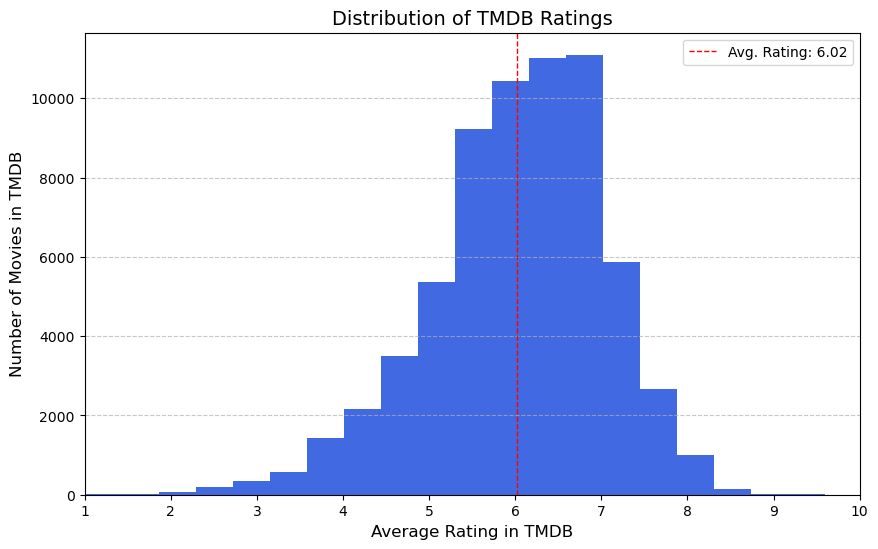

In [81]:
plt.figure(figsize=(10, 6))
plt.hist(
    movies_tmdb.vote_average, 
    bins=20,  
    color="royalblue", 
)

plt.ylabel("Number of Movies in TMDB", fontsize=12)
plt.xlabel("Average Rating in TMDB", fontsize=12)
plt.title("Distribution of TMDB Ratings", fontsize=14)
plt.xticks(range(1, 11, 1), fontsize=10)
plt.xlim(1, 10)

plt.grid(axis="y", linestyle="--", alpha=0.7)
avg_rating = movies_tmdb.vote_average.mean()
plt.axvline(avg_rating, color="red", linestyle="--", linewidth=1, label=f"Avg. Rating: {avg_rating:.2f}")
plt.legend()
plt.show()

What we see here is expected: the average rating of most movies is around 6. This can be assumed because most people voting on these kinds of platforms are either those who really liked the movie, giving it a rating of 9 or 10, or those who hated it, rating it around 1. As we see, there are almost no movies with an average rating close to 1 or 10.

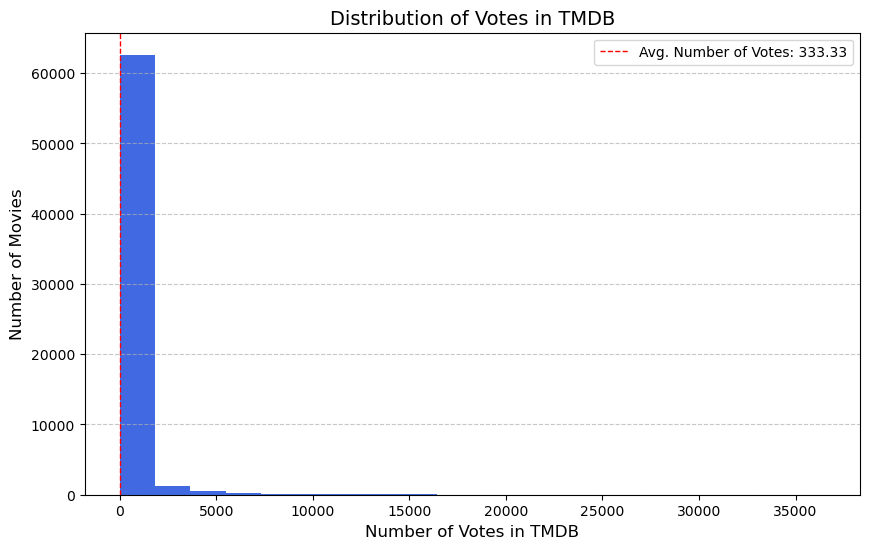

In [82]:
plt.figure(figsize=(10, 6)) 
plt.hist(
    movies_tmdb.vote_count, 
    bins=20,  
    color="royalblue", 
)

plt.ylabel("Number of Movies", fontsize=12)
plt.xlabel("Number of Votes in TMDB", fontsize=12)
plt.title("Distribution of Votes in TMDB", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(avg_rating, color="red", linestyle="--", linewidth=1, label=f"Avg. Number of Votes: {movies_tmdb.vote_count.mean():.2f}")
plt.legend()
plt.show()

In [83]:
movies_tmdb[movies_tmdb.vote_count<2000].shape

(62817, 16)

As we can see the average vote count of the movies that we have left is pretty low, only about 300. And from those 70000 movies 67000 of them have less than 2000 votes.

Let's now see the the average rating and count from IMDB.

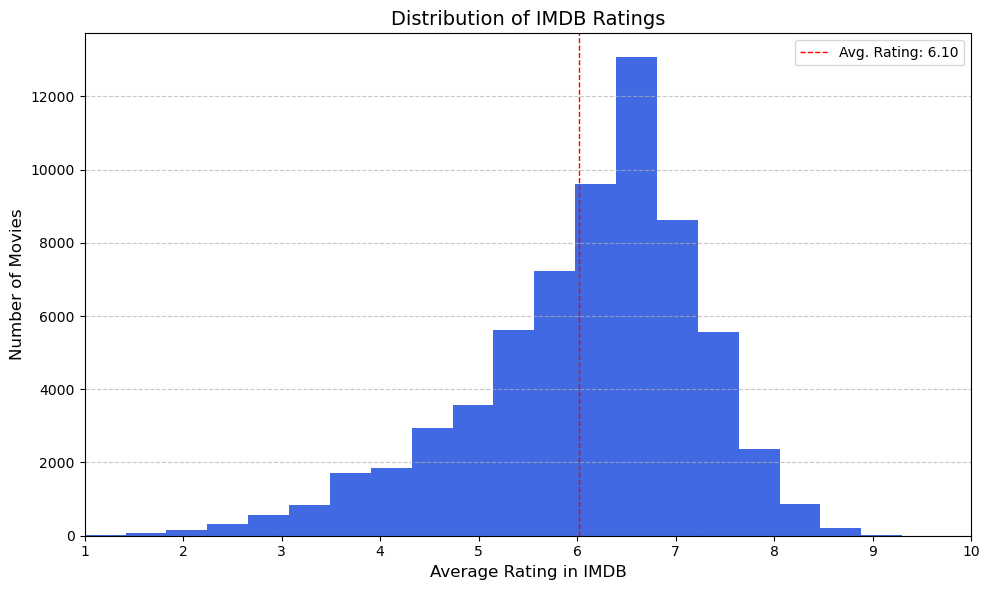

In [84]:
plt.figure(figsize=(10, 6))  
plt.hist(
    movies_tmdb.imdb_rating, 
    bins=20,  
    color="royalblue",
)


plt.ylabel("Number of Movies", fontsize=12)
plt.xlabel("Average Rating in IMDB", fontsize=12)
plt.title("Distribution of IMDB Ratings", fontsize=14)
plt.xticks(range(1, 11, 1), fontsize=10)
plt.xlim(1, 10)


plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(avg_rating, color="red", linestyle="--", linewidth=1, label=f"Avg. Rating: {movies_tmdb.imdb_rating.mean():.2f}")
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
imdb_rating = movies_tmdb.imdb_rating.mean()

Here we see almost the same situetion as the ratings in TMDB. The average rating for a movie is still around 6. And for the most extreme values - 1 and 10 we don't have a lot of movies.

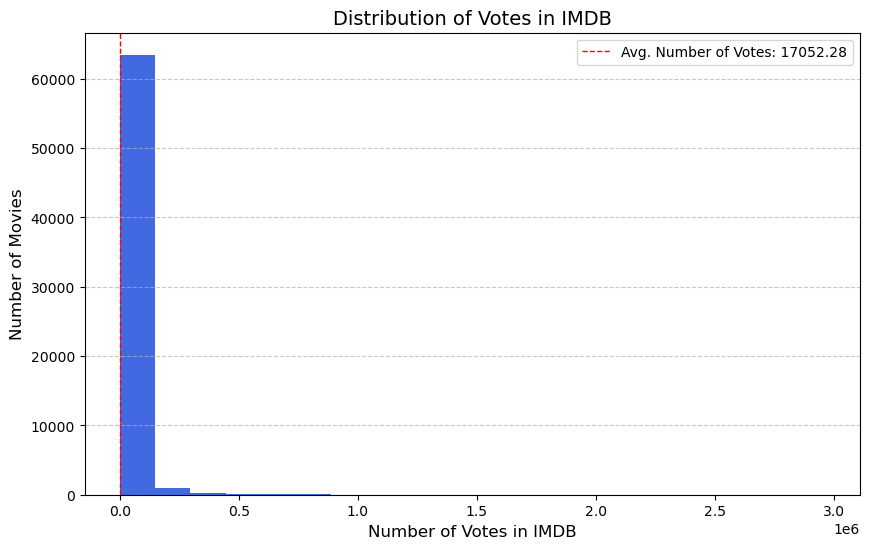

In [86]:
plt.figure(figsize=(10, 6)) 
plt.hist(
    movies_tmdb.imdb_votes, 
    bins=20,  
    color="royalblue", 
)

plt.ylabel("Number of Movies", fontsize=12)
plt.xlabel("Number of Votes in IMDB", fontsize=12)
plt.title("Distribution of Votes in IMDB", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(avg_rating, color="red", linestyle="--", linewidth=1, label=f"Avg. Number of Votes: {movies_tmdb.imdb_votes.mean():.2f}")
plt.legend()
plt.show()

In [87]:
movies_tmdb.imdb_votes.mean()

17052.279173251907

For the IMDB movies we notice that the average amount of votes is signifiacntly larger. This is because of the populariy of the platforms themselvs. IMDB is the most popular platform where people rate and comment on movies, so this result was expected.

From the metadata for the TMDB movies we see that the popularity colum represent the popularity score on TMDB. This popularity score on TMDB is calculated by using all of these attributes

    -Number of votes for the day
    
    -Number of views for the day
    
    -Number of users who marked it as a "favourite" for the day
    
    -Number of users who added it to their "watchlist" for the day
    
    -Release date
    
    -Number of total votes
    
    -Previous days score

We don't have access to all of these attributes, but it is good to have them in mind when we are working with the popularity score.

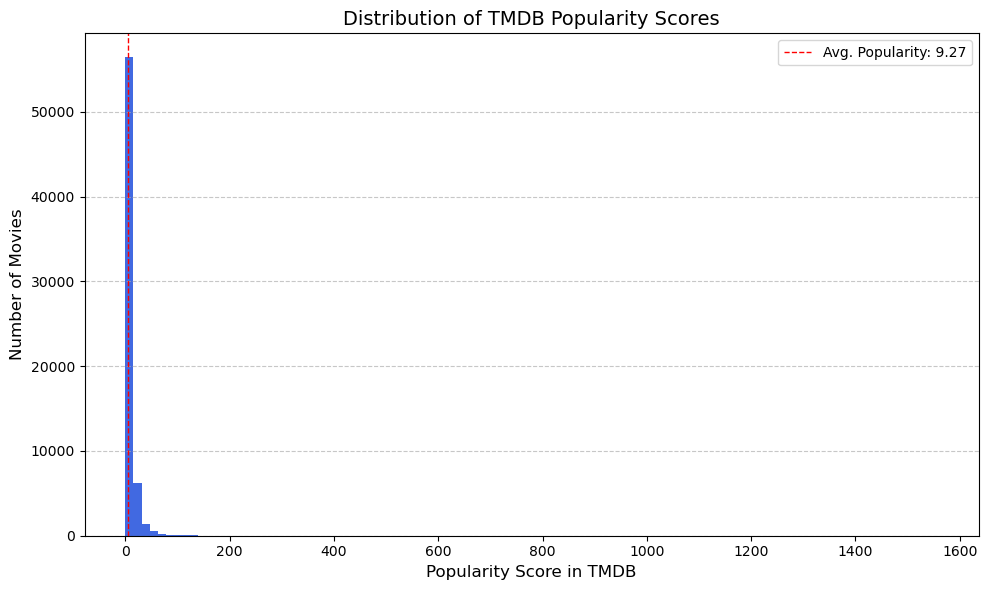

In [88]:
plt.figure(figsize=(10, 6))  
plt.hist(
    movies_tmdb.popularity, 
    bins=100,  
    color="royalblue", 
    
)

plt.ylabel("Number of Movies", fontsize=12)
plt.xlabel("Popularity Score in TMDB", fontsize=12)
plt.title("Distribution of TMDB Popularity Scores", fontsize=14)


plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.axvline(avg_rating, color="red", linestyle="--", linewidth=1, label=f"Avg. Popularity: {movies_tmdb.popularity.mean():.2f}")
plt.legend()

plt.tight_layout()
plt.show()

The popularity variable is also strongly right-skewed, similar to the distribution of votes per movie.

In [89]:
movies_tmdb[movies_tmdb.popularity>150].shape

(75, 16)

We can see that only 75 movies have a popularity rating score above 150, compared to the 70,000 movies in our dataset.
Let's for just for example take a look at some of those most popular movies.

In [90]:
movies_tmdb[movies_tmdb.popularity>150].sample(5)

,title,vote_average,vote_count,release_date,runtime,imdb_id,original_language,overview,popularity,genres,spoken_languages,cast,director,writers,imdb_rating,imdb_votes
61603,Terrifier,6.309,175.0,2011-08-09,19.0,2018130,en,After witnessing a brutal murder on Halloween ...,472.220,Horror,English,"Gary LoSavio, Marie Maser, Mike Giannelli, Mic...",Damien Leone,Damien Leone,6.4,3597.0
86,The Lord of the Rings: The Return of the King,8.500,24151.0,2003-12-17,201.0,167260,en,As armies mass for a final battle that will de...,336.574,"Adventure, Fantasy, Action",English,"Ian McKellen, Ian Holm, Rick Porras, John Step...",Peter Jackson,"J. R. R. Tolkien, Philippa Boyens, Peter Jacks...",9.0,2026504.0
5531,Hocus Pocus,7.000,2979.0,1993-07-16,96.0,107120,en,"After 300 years of slumber, three sister witch...",155.727,"Fantasy, Comedy, Family","English, Français","Doug Jones, Garry Marshall, Omri Katz, Jeff Ne...",Kenny Ortega,"David Kirschner, Neil Cuthbert, Mick Garris",6.9,162378.0
116624,The Maze Runner,7.200,16927.0,2014-09-10,113.0,1790864,en,"Set in a post-apocalyptic world, young Thomas ...",184.910,"Action, Mystery, Science Fiction, Thriller",English,"Tyler Harrison, Landon Hazel, Darryl Harvey, G...",Wes Ball,"James Dashner, Grant Pierce Myers, Noah Oppenh...",6.8,523840.0
326313,Joker,8.149,25623.0,2019-10-01,122.0,7286456,en,"During the 1980s, a failed stand-up comedian i...",176.017,"Crime, Thriller, Drama",English,"Greer Barnes, Sam Morril, Brett Cullen, Murphy...",Todd Phillips,"Jerry Robinson, Bob Kane, Todd Phillips, Bill ...",8.4,1557782.0


In [91]:
movies_tmdb[movies_tmdb.popularity>150].vote_count.mean(), movies_tmdb[movies_tmdb.popularity>150].imdb_votes.mean()

(11223.866666666667, 587385.7866666666)

Here we can see the massive difference in the vote count in respect to all of the movies.

In [92]:
movies_tmdb[movies_tmdb.popularity>150].vote_average.mean(), movies_tmdb[movies_tmdb.popularity>150].imdb_rating.mean()

(7.29956, 7.052000000000001)

As well the average rating on both platforms is a lot higher as expected for the more popular movies.

Now let's look at the user ratings from the Movie Lens dataset and analyze their ditribution.

In [93]:
movie_ratings.rating.value_counts()

rating
4.0    8293295
3.0    6011494
5.0    4549570
3.5    4247315
4.5    2940097
2.0    2014942
2.5    1670863
1.0     938070
1.5     526803
0.5     516092
Name: count, dtype: int64

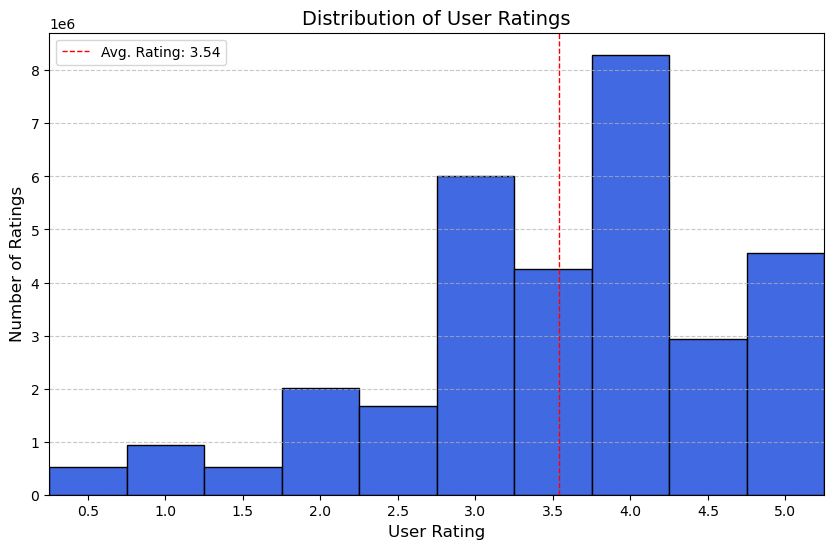

In [94]:
rating_counts = movie_ratings.rating.value_counts().sort_index()

plt.figure(figsize=(10, 6))  
plt.bar(rating_counts.index, rating_counts.values, color="royalblue", edgecolor="black",width=0.5  )

plt.xlabel("User Rating", fontsize=12)
plt.ylabel("Number of Ratings", fontsize=12)
plt.title("Distribution of User Ratings", fontsize=14)

plt.xticks(np.arange(0.5, 5.5, 0.5), fontsize=10)
plt.xlim(0.25, 5.25)  

plt.grid(axis="y", linestyle="--", alpha=0.7)

avg_rating = movie_ratings.rating.mean()
plt.axvline(avg_rating, color="red", linestyle="--", linewidth=1, label=f"Avg. Rating: {avg_rating:.2f}")
plt.legend()

plt.show()

The average user rating is approximately 3.5 (equivalent to 7 on a 1–10 scale). But why is the average movie rating around 6? Where does this difference come from?

We can assume that the higher average rating of 7 is due to more popular movies receiving both higher ratings and more votes, while smaller, less popular movies receive fewer votes and generally lower ratings. When calculating the average rating for a movie in the TMDB dataset, both popular and less popular movies are treated equally. For example, if a popular movie has 100,000 votes with an average rating of 8.0, and a less popular movie has 100 votes with an average rating of 4.0, the combined average rating becomes 6.

Let’s quickly test this assumption by calculating the average rating for movies with a significant number of votes, such as those with more than 10,000 votes, considering that the average number of ratings on IMDb is 15,000.

In [95]:
AMOUNT_OF_VOTES = [1000, 10000, 20000, 50000, 100000]
for votes in AMOUNT_OF_VOTES:
    print(f"Average Rating for movies wiht more than {votes} votes - {movies_tmdb[movies_tmdb.imdb_votes>votes].imdb_rating.mean()}")


Average Rating for movies wiht more than 1000 votes - 6.258610083024907
Average Rating for movies wiht more than 10000 votes - 6.603382778581765
Average Rating for movies wiht more than 20000 votes - 6.684498111171074
Average Rating for movies wiht more than 50000 votes - 6.83639846743295
Average Rating for movies wiht more than 100000 votes - 7.018281758957655


Now we see how the average rating increases with number of vote counts and that is why the average rating in the movie_ratings dataset is 7. Because most of the ratings there are for the more popular movies.

In [96]:
movies_tmdb.describe()

,vote_average,vote_count,release_date,runtime,imdb_id,popularity,imdb_rating,imdb_votes
count,65171.000000,65171.000000,65171,65171.000000,6.517100e+04,65171.000000,65171.000000,6.517100e+04
mean,6.023950,333.325636,1996-01-22 02:37:37.850884608,96.483958,2.613075e+06,9.269345,6.097190,1.705228e+04
min,1.000000,5.000000,1896-01-01 00:00:00,1.000000,9.100000e+01,0.020000,1.000000,5.000000e+01
25%,5.400000,14.000000,1981-01-20 12:00:00,86.000000,8.763250e+04,3.187000,5.500000,6.140000e+02
50%,6.100000,34.000000,2005-08-13 00:00:00,95.000000,4.356230e+05,5.603000,6.300000,1.523000e+03
75%,6.726500,119.000000,2015-08-28 00:00:00,107.000000,3.541856e+06,10.258500,6.900000,5.191500e+03
max,9.600000,36495.000000,2024-07-18 00:00:00,12480.000000,2.908110e+07,1558.152000,9.300000,2.960367e+06
std,1.021014,1390.266939,NaN,55.622964,4.121994e+06,16.405376,1.158505,7.912020e+04


Here we can observe that no movie has an average rating of 10, although there are movies with a rating of 1. The average runtime of a movie is approximately 96 minutes, and the release dates of the movies range from 1896 to 2024.

Now, let’s dive a bit deeper into the release dates by plotting the number of movies released per year to observe how the movie industry has evolved over time.

/var/folders/6f/pgdvkqt91lq31wb_lcq5cwr80000gn/T/ipykernel_20969/576002834.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


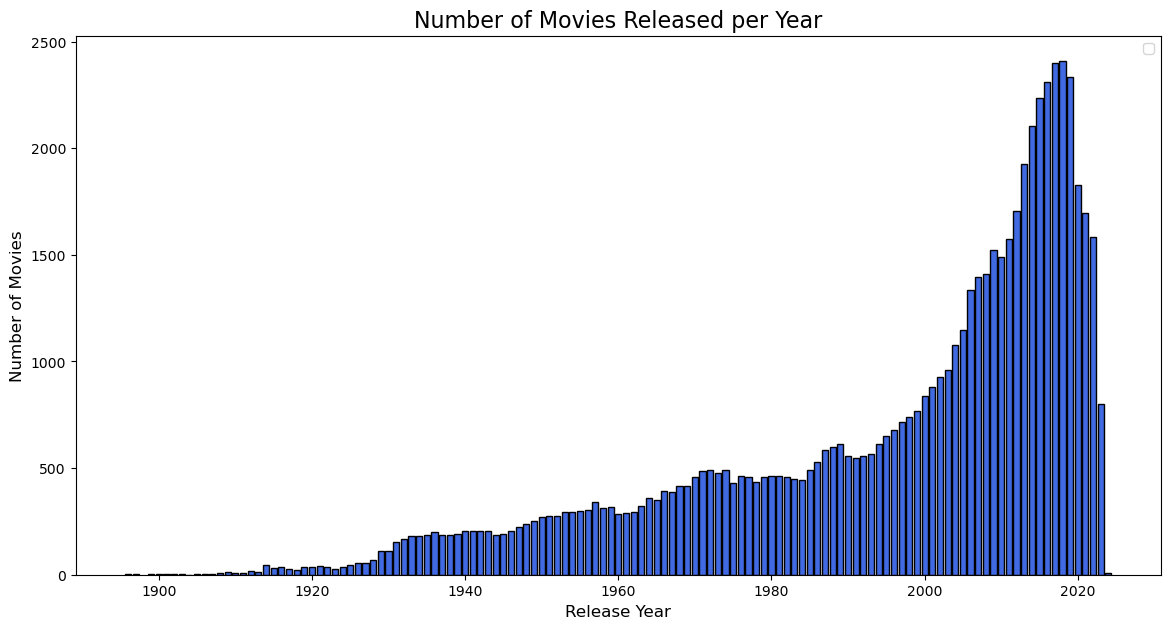

In [97]:
movies_per_year = movies_tmdb['release_date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(14, 7))  
plt.bar(movies_per_year.index, movies_per_year.values, color="royalblue", edgecolor="black", width=0.8)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)

plt.title("Number of Movies Released per Year", fontsize=16)
plt.legend()
plt.show()

As expected, movie production has increased significantly over the years. However, it has started to slowly decrease again since 2018. This could also be due to some of the newer movies being missing from our dataset.

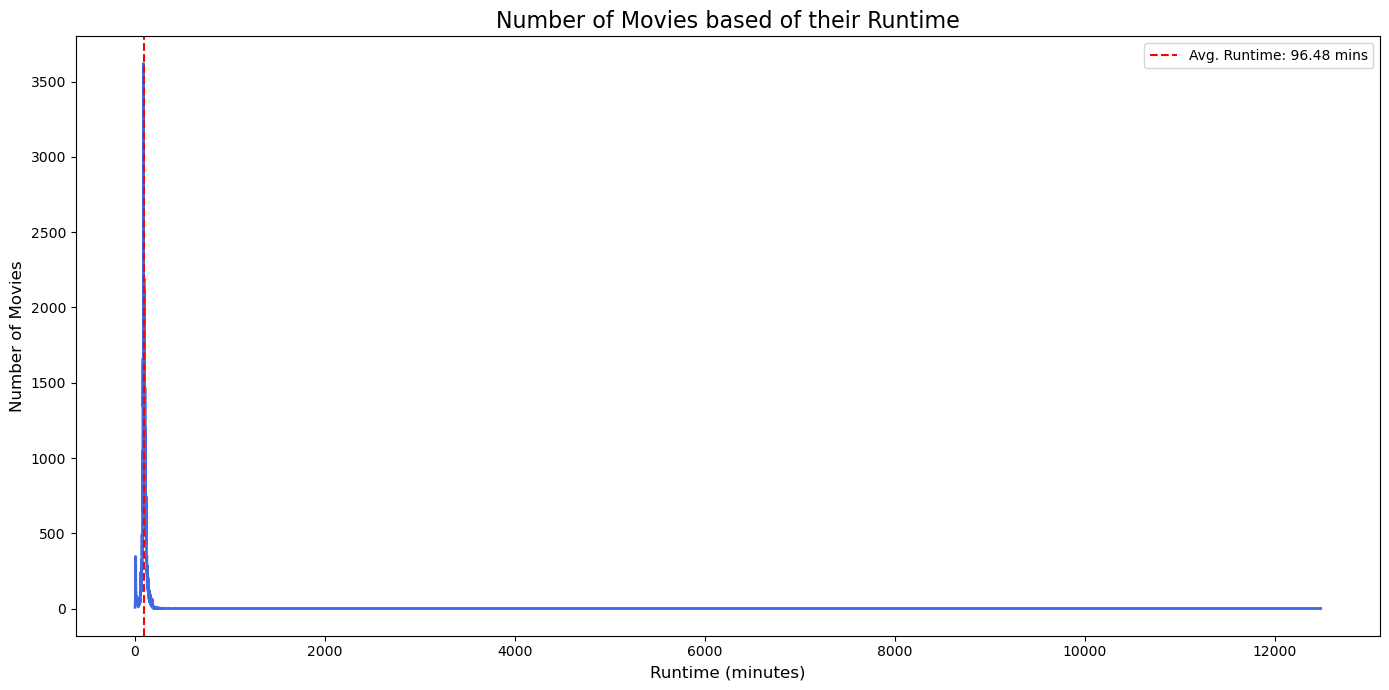

In [98]:
 
movies_per_runtime = movies_tmdb['runtime'].value_counts().sort_index()
plt.figure(figsize=(14, 7))  

plt.plot(movies_per_runtime.index, movies_per_runtime.values, color="royalblue", linewidth=2)

plt.xlabel("Runtime (minutes)", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.title("Number of Movies based of their Runtime", fontsize=16)
plt.legend(['Number of Movies'])
avg_runtime = movies_tmdb['runtime'].mean()

plt.axvline(avg_runtime, color="red", linestyle="--", linewidth=1.5, label=f"Avg. Runtime: {avg_runtime:.2f} mins")
plt.legend()
plt.tight_layout()

plt.show()

There are some extreme values for the runtime there are movies that have above 12000 runtime. So let's plot this graph again but with max amount of 300 minut

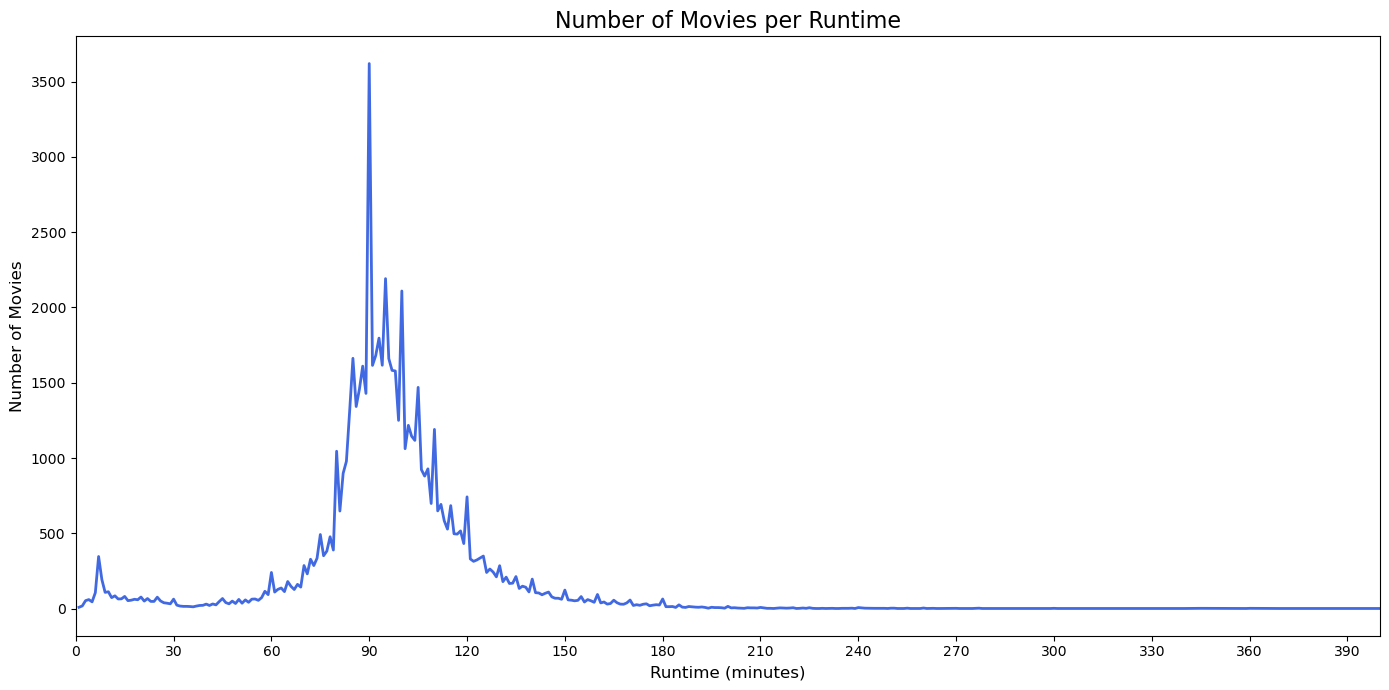

In [99]:
filter_runtime = movies_tmdb[movies_tmdb['runtime'] <= 400]
movies_per_runtime = filter_runtime['runtime'].value_counts().sort_index()

plt.figure(figsize=(14, 7))  
plt.plot(movies_per_runtime.index, movies_per_runtime.values, color="royalblue", linewidth=2)

plt.xlabel("Runtime (minutes)", fontsize=12)

plt.ylabel("Number of Movies", fontsize=12)

plt.title("Number of Movies per Runtime", fontsize=16)

plt.xlim(0, 400) 

plt.xticks(np.arange(0, 401, 30), fontsize=10)
plt.tight_layout()
    

Finnaly now let's look at the correlations of all the numerical features we have looked into so far.

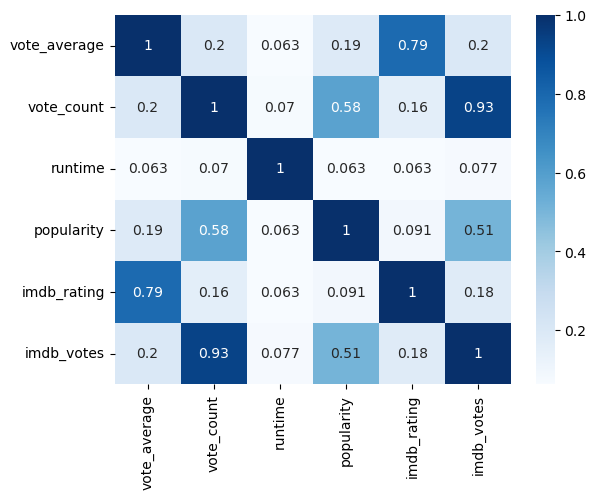

In [100]:
numerical_columns = movies_tmdb[["vote_average","vote_count","runtime","popularity","imdb_rating","imdb_votes"]]
corr_matrix = numerical_columns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.show()

 As expected the average rating in IMDB and TMDB have high correlation, as well as the amount of votes in IMDB and TMDB. We also see that the popularity metric for the movies have a high correlation with the amount of votes movies havem which is expected. Because that is one of the main attributes that is used for calculating the popularity score. 

Now let's look at the genres of the movies.

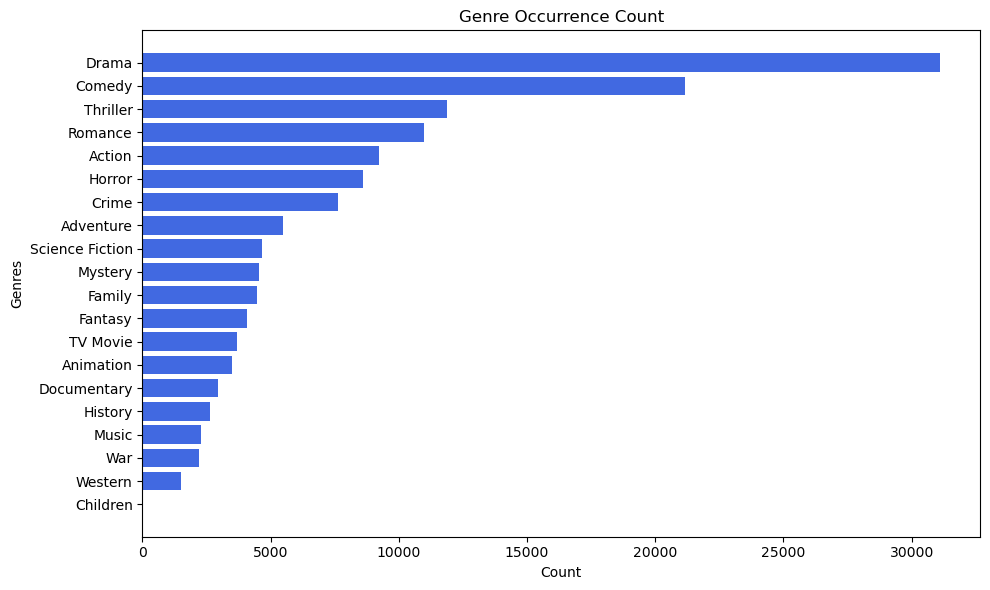

In [101]:
genres_list = movies_tmdb['genres'].apply(lambda x: x.split(', ')).tolist()
genres = [genre for sublist in genres_list for genre in sublist]
genre_counts = Counter(genres)
sorted_counts = sorted(genre_counts.items(), key=lambda x: x[1])
genres, counts = zip(*sorted_counts)


plt.figure(figsize=(10, 6))
plt.barh(genres, counts, color='royalblue') 
plt.title('Genre Occurrence Count')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.tight_layout()
plt.show()

So the genres which appear the most on the movies are drama and comedy. We have one movie with genre Children. Let's manually look at this movie and decide what we will do with the genre.

In [102]:
movies_tmdb.loc[movies_tmdb.genres.str.contains("Children"), 'genres'] = (
    movies_tmdb.loc[movies_tmdb.genres.str.contains("Children"), 'genres']
    .str.replace("Children", "Family")
)

By looking at the movie online in IMDB, the genre there is Family instead of Children so we can change it to Family.

Now let's look at the cast and who are the acttors with the most movies

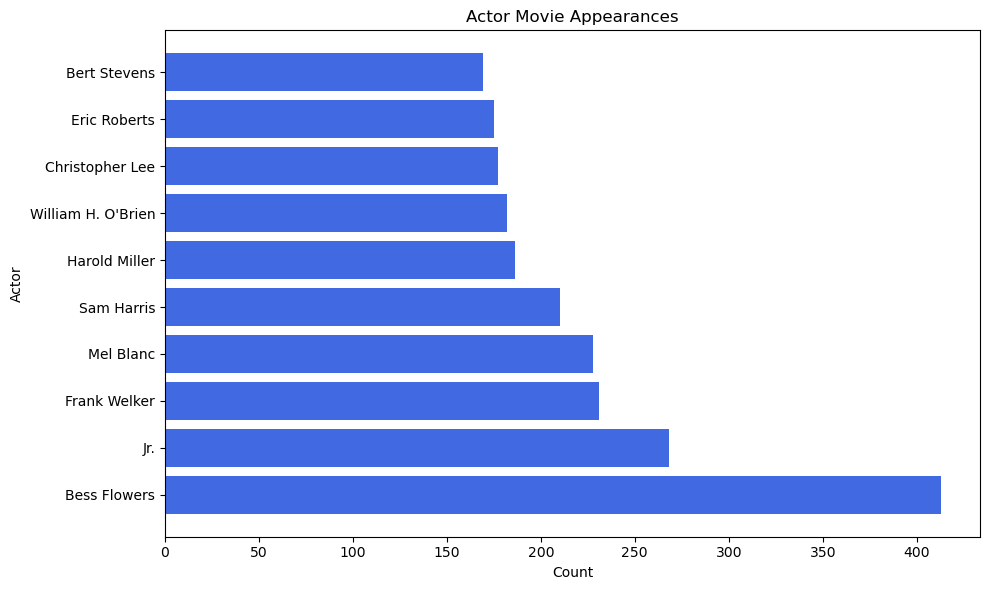

In [103]:
cast_list = movies_tmdb['cast'].apply(lambda x: x.split(', ')).tolist()
actors = [cast for sublist in cast_list for cast in sublist]
actors_counts = Counter(actors)
top_10_actors = actors_counts.most_common(10)
top_10_actor_names, counts = zip(*top_10_actors)


plt.figure(figsize=(10, 6))
plt.barh(top_10_actor_names, counts, color='royalblue') 
plt.title('Actor Movie Appearances')
plt.xlabel('Count')
plt.ylabel('Actor')
plt.tight_layout()
plt.show()

In [104]:
len(actors_counts)

509673

There are over 420000 different cast members for our movies.

In [105]:
pd.set_option('display.max_colwidth', None)
print(movies_tmdb[movies_tmdb.cast.str.contains(", Jr.,")].sample(2).cast)


147205                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Here we have a problem with the name Jr. because it is not properly included. The places where only Jr. exists. It is meant to be connected with the name beforehand.

In [106]:
pd.reset_option('display.max_colwidth')

In [107]:
def fix_jr(cast_string):
    """
    Corrects the formatting of 'Jr.' in a cast string.
    
    Parameters:
    - cast_string (str): A string containing cast members separated by commas.
    
    Returns:
    - str: A corrected cast string with 'Jr.' properly appended to the preceding name.
    """

    parts = cast_string.split(', ')
    corrected_parts = []
    skip_next = False
    
    for i in range(len(parts)):
        if skip_next:
            skip_next = False
            continue
        
        if i > 0 and parts[i].strip() == 'Jr.':
            corrected_parts[-1] = f"{corrected_parts[-1]} Jr."
            skip_next = True  
        else:
            corrected_parts.append(parts[i])
    
    return ', '.join(corrected_parts)

movies_tmdb["cast"] = movies_tmdb['cast'].apply(fix_jr)



In [108]:
movies_tmdb[movies_tmdb.cast.str.contains(",Jr.,")].cast

Series([], Name: cast, dtype: object)

Ok we have successfully removed the the name "Jr." and combined it with the correct name. 

These top 10 people have all participated in more than 150 movies. Let’s check real quick their movies’ average rating to see if there is any correlation with the number of times a person appears in the cast.

In [109]:
movies_with_top_actors = movies_tmdb[movies_tmdb['cast'].apply(
    lambda x: any(actor in x for actor in top_10_actor_names)
)]

actor_ratings = {actor: [] for actor in top_10_actor_names}

for _, row in movies_with_top_actors.iterrows():
    for actor in top_10_actor_names:
        if actor in row['cast']:
            actor_ratings[actor].append(row['imdb_rating'])  


average_ratings = {
    actor: sum(ratings) / len(ratings) if ratings else 0
    for actor, ratings in actor_ratings.items()
}


for actor, avg_rating in average_ratings.items():
    print(f"{actor}: {avg_rating:.2f}")

Bess Flowers: 6.69
Jr.: 6.08
Frank Welker: 6.19
Mel Blanc: 7.02
Sam Harris: 6.89
Harold Miller: 6.81
William H. O'Brien: 6.81
Christopher Lee: 6.00
Eric Roberts: 4.66
Bert Stevens: 6.86


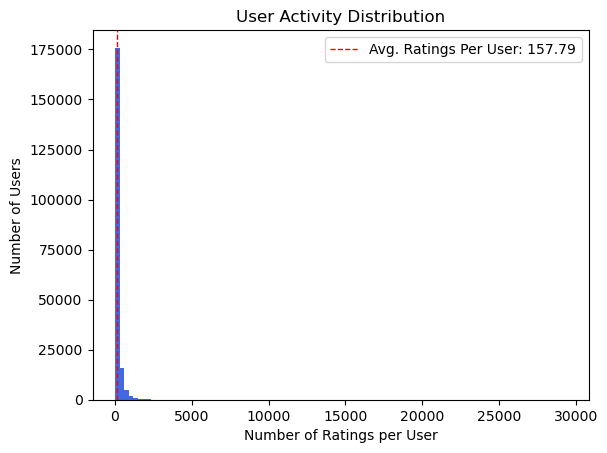

In [110]:
user_counts = movie_ratings['user_id'].value_counts()
plt.hist(user_counts, color = "royalblue" ,bins=100)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.title('User Activity Distribution')
avg_user_ratings= user_counts.values.mean()
plt.axvline(avg_user_ratings, color="red", linestyle="--", linewidth=1, label=f"Avg. Ratings Per User: {avg_user_ratings:.2f}")
plt.legend()
plt.show()

Now let's analyze the spoken languages and the original language columns the same way we did with the genres one.

In [111]:
spoken_languages_list = movies_tmdb['spoken_languages'].apply(lambda x: x.split(',')).tolist()
spoken_languages = [spoken_language for sublist in spoken_languages_list for spoken_language in sublist]
spoken_languages_counts = Counter(spoken_languages)
spoken_languages_counts

Counter({'English': 38627,
         ' English': 4080,
         'Français': 3982,
         ' Français': 2667,
         'Español': 2505,
         '日本語': 2500,
         'Italiano': 2386,
         'Deutsch': 2343,
         ' Español': 2077,
         ' Italiano': 1748,
         'Pусский': 1623,
         ' Deutsch': 1351,
         '普通话': 1021,
         ' Pусский': 958,
         'हिन्दी': 937,
         '한국어/조선말': 900,
         'No Language': 870,
         'Português': 674,
         ' 日本語': 643,
         '广州话 / 廣州話': 638,
         ' ': 590,
         ' Português': 587,
         'العربية': 508,
         'svenska': 461,
         'Polski': 446,
         ' 普通话': 433,
         ' svenska': 419,
         'Nederlands': 399,
         'suomi': 395,
         'Dansk': 381,
         'Türkçe': 335,
         'தமிழ்': 334,
         ' Polski': 309,
         'Český': 284,
         ' हिन्दी': 271,
         ' 广州话 / 廣州話': 239,
         ' עִבְרִית': 231,
         '': 221,
         ' Magyar': 212,
         ' Latin': 

First we notice that there are some whitespaces that should be removed from the text.

In [112]:
spoken_languages_list = movies_tmdb['spoken_languages'].apply(lambda x: [lang.strip() for lang in x.split(',')]).tolist()
spoken_languages = [spoken_language for sublist in spoken_languages_list for spoken_language in sublist]
spoken_languages_counts = Counter(spoken_languages)
print(spoken_languages_counts)
print(len(spoken_languages_counts))

Counter({'English': 42707, 'Français': 6649, 'Español': 4582, 'Italiano': 4134, 'Deutsch': 3694, '日本語': 3143, 'Pусский': 2581, '普通话': 1454, 'Português': 1261, 'हिन्दी': 1208, '한국어/조선말': 1095, 'No Language': 905, 'svenska': 880, '广州话 / 廣州話': 877, '': 811, 'Polski': 755, 'العربية': 679, 'Nederlands': 553, 'Türkçe': 513, 'suomi': 502, 'Dansk': 446, 'தமிழ்': 421, 'Magyar': 381, 'Český': 381, 'עִבְרִית': 375, 'ελληνικά': 356, 'Norsk': 351, 'ภาษาไทย': 296, 'فارسی': 281, 'Latin': 250, 'తెలుగు': 232, 'Română': 224, 'Srpski': 140, 'Український': 138, 'Tiếng Việt': 126, 'Bahasa indonesia': 114, 'বাংলা': 104, 'Íslenska': 97, 'اردو': 84, 'Català': 80, 'Hrvatski': 80, 'Eesti': 73, 'ქართული': 68, 'български език': 59, 'Afrikaans': 58, 'Bosanski': 51, 'Slovenčina': 50, 'Kiswahili': 48, 'ਪੰਜਾਬੀ': 45, 'shqip': 44, 'Gaeilge': 43, 'Lietuvių': 42, 'Bahasa melayu': 42, 'Latviešu': 39, '?????': 38, 'euskera': 32, 'Cymraeg': 28, 'Slovenščina': 27, 'isiZulu': 26, 'Wolof': 25, 'қазақ': 21, 'Galego': 20, 'Azərb

There are 79 unique languages in our list. We obviously can't use them all because for most of them there is a too low amount of occurences. We can try to fix this problem by working f.e only with the top 10 languages and extract only them. If a movie doesn't contain a language from the top 10 we will remove the movies. And we will leave only the top 10 languages for every movie. Firstly we notice that there is the language "No Language", let's check these movies if we need to remove them.

In [113]:
movies_tmdb[movies_tmdb.spoken_languages == "No Language"].shape
movies_tmdb = movies_tmdb[~(movies_tmdb.spoken_languages == "No Language")]
movies_tmdb.shape

(64314, 16)

In [114]:
spoken_languages_list = movies_tmdb['spoken_languages'].apply(lambda x: [lang.strip() for lang in x.split(',')]).tolist()
spoken_languages = [spoken_language for sublist in spoken_languages_list for spoken_language in sublist]
spoken_languages_counts = Counter(spoken_languages)

top_10_languages = [lang for lang, count in spoken_languages_counts.most_common(10)]
movies_without_top_10 = movies_tmdb[~movies_tmdb['spoken_languages'].apply(
    lambda x: any(lang.strip() in top_10_languages for lang in x.split(','))
)]
movies_without_top_10.shape

(5709, 16)

4500 movies don't have any of the languages from the top 10 most spoken ones. We have to remove them. Because not a lot of movies contain the other languages

In [115]:
movies_tmdb = movies_tmdb[movies_tmdb['spoken_languages'].apply(
    lambda x: any(lang.strip() in top_10_languages for lang in x.split(','))
)]

movies_tmdb.spoken_languages = movies_tmdb.spoken_languages.str.split(",").apply(lambda x: [item.strip() for item in x])
movies_tmdb.spoken_languages = movies_tmdb.spoken_languages.apply(lambda x: [language for language in x if language in top_10_languages])


/opt/anaconda3/envs/movie_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/movie_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/movie_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/movie_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26222 (\N{CJK UNIFIED IDEOGRAPH-666E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/movie_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: G

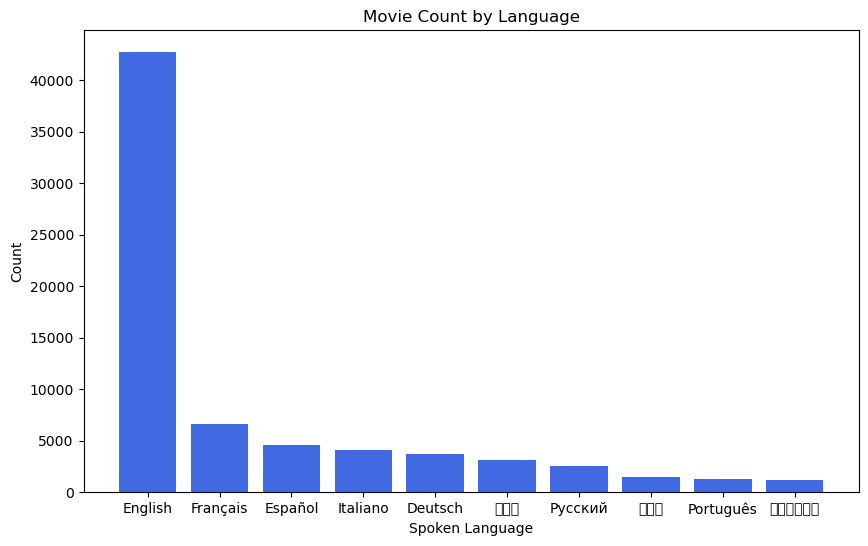

In [116]:
spoken_languages_count_dataset = movies_tmdb.explode('spoken_languages')
spoken_languages_counts = spoken_languages_count_dataset['spoken_languages'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(spoken_languages_counts.index, spoken_languages_counts.values,color='royalblue')
plt.title('Movie Count by Language')
plt.xlabel('Spoken Language')
plt.ylabel('Count')
plt.show()

The symbols that are not showing are the chinese symbols.

We are going to the the same thing with the original language now.

In [117]:
orignal_languages_list = movies_tmdb['original_language'].apply(lambda x: [lang.strip() for lang in x.split(',')]).tolist()
original_languages = [original_language for sublist in orignal_languages_list for original_language in sublist]
orignal_languages_counts = Counter(original_languages)
print(orignal_languages_counts)
print(len(orignal_languages_counts))
top_10_languages = [lang for lang, count in orignal_languages_counts.most_common(15)]
movies_without_top_10 = movies_tmdb[~movies_tmdb['original_language'].apply(
    lambda x: any(lang.strip() in top_10_languages for lang in x.split(','))
)]
print(movies_without_top_10.shape)

Counter({'en': 39235, 'fr': 4051, 'it': 2698, 'ja': 2559, 'es': 2256, 'ru': 1611, 'de': 1565, 'hi': 1044, 'zh': 829, 'pt': 701, 'cn': 309, 'sv': 187, 'ko': 156, 'nl': 139, 'pl': 109, 'da': 98, 'fi': 77, 'no': 70, 'he': 59, 'tl': 56, 'el': 53, 'hu': 52, 'cs': 51, 'ar': 46, 'th': 44, 'ml': 42, 'uk': 37, 'ro': 33, 'fa': 29, 'ca': 26, 'is': 24, 'tr': 24, 'ta': 23, 'et': 23, 'bn': 20, 'sr': 20, 'lv': 15, 'kk': 14, 'id': 14, 'lt': 13, 'ka': 12, 'sh': 11, 'wo': 9, 'bs': 8, 'sk': 8, 'bg': 7, 'te': 7, 'hr': 7, 'ku': 6, 'mk': 6, 'ur': 6, 'eu': 6, 'hy': 5, 'ms': 5, 'vi': 4, 'sl': 4, 'sq': 4, 'af': 4, 'kn': 4, 'xx': 3, 'bo': 3, 'ps': 3, 'bm': 3, 'km': 3, 'ln': 3, 'az': 3, 'mr': 3, 'ne': 3, 'pa': 3, 'gl': 3, 'sw': 3, 'am': 2, 'xh': 2, 'la': 2, 'so': 2, 'qu': 2, 'ga': 2, 'ak': 2, 'mt': 2, 'tn': 1, 'si': 1, 'tg': 1, 'fo': 1, 'sc': 1, 'iu': 1, 'ay': 1, 'lo': 1, 'my': 1, 'yi': 1, 'ky': 1, 'as': 1, 'os': 1, 'dz': 1, 'rw': 1, 'su': 1, 'se': 1, 'mi': 1})
97
(1156, 16)


Here there are 92 unique original languages and 1772 movies don't have one of these top 10 languages. So we are going to remove them for now. The count for the other is movie is too little. There are below 200 occurences for the original languages outside of the top 10, which is again too little to bring us any valuable information.

In [118]:
movies_tmdb = movies_tmdb[movies_tmdb['original_language'].apply(
    lambda x: any(lang.strip() in top_10_languages for lang in x.split(','))
)]

Now let's plot both of the columns original language and spoken languages so we can see the popularity each language has.

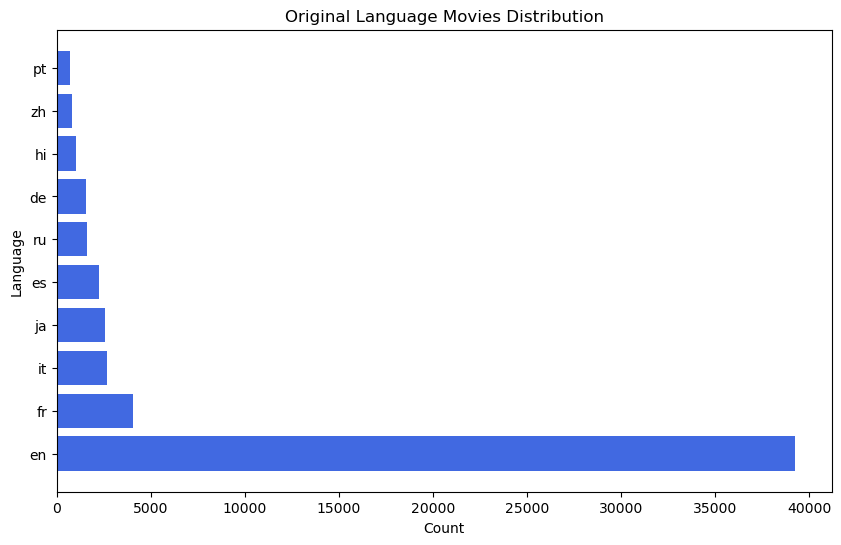

In [119]:
top_10_or_languages, counts = zip(*orignal_languages_counts.most_common(10))
plt.figure(figsize=(10, 6))
plt.barh(top_10_or_languages, counts, color='royalblue')  
plt.title('Original Language Movies Distribution')
plt.xlabel('Count')
plt.ylabel('Language')
plt.show()

In [120]:
writers_list = movies_tmdb['writers'].apply(lambda x: [writer.strip() for writer in x.split(',')]).tolist()
writers = [writer for sublist in writers_list for writer in sublist]
writers_count = Counter(writers)
print(len(writers_count))

53008


There are over 50000 unqiue writers, let's plot the most popular ones.

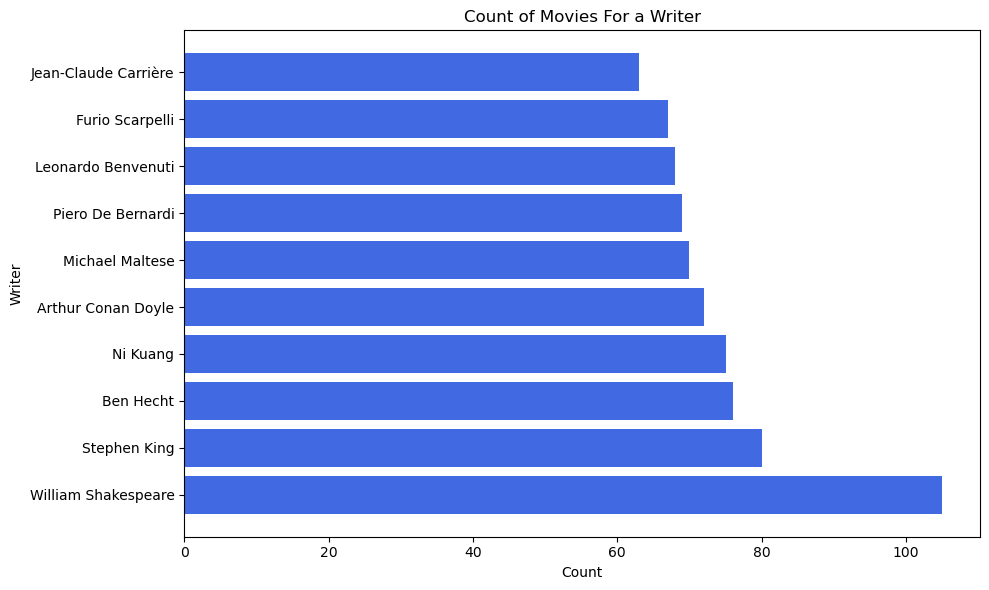

In [121]:
writers_list = movies_tmdb['writers'].apply(lambda x: [writer.strip() for writer in x.split(',')]).tolist()
writers = [writer for sublist in writers_list for writer in sublist]
writers_count = Counter(writers)
top_10_writers = writers_count.most_common(10)
top_10_writer_names, counts = zip(*top_10_writers)


plt.figure(figsize=(10, 6))
plt.barh(top_10_writer_names, counts, color='royalblue')  
plt.title('Count of Movies For a Writer')
plt.xlabel('Count')
plt.ylabel('Writer')
plt.tight_layout()
plt.show()

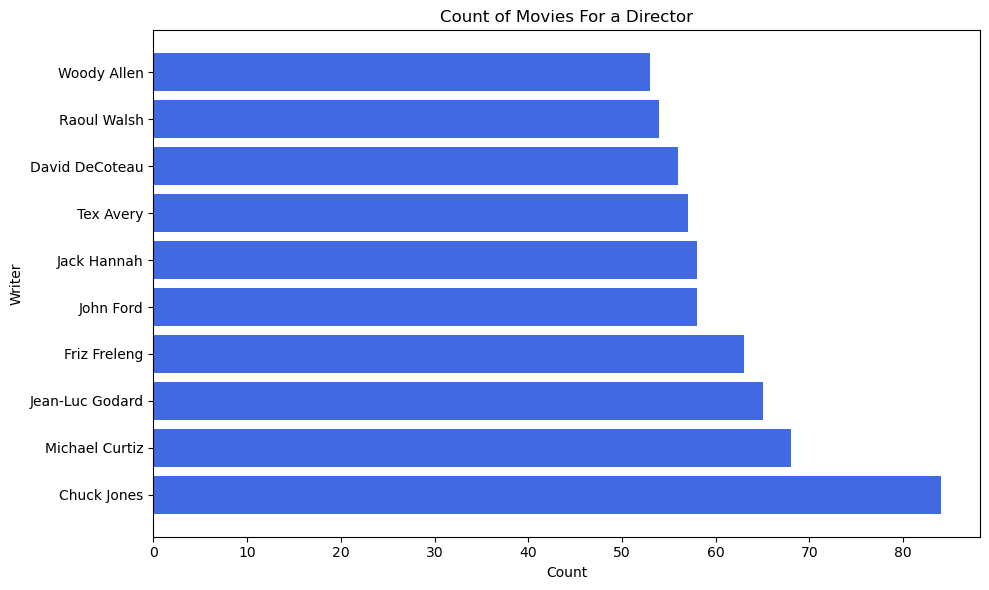

Unique Directors - 23898


In [122]:
director_list = movies_tmdb['director'].apply(lambda x: [director.strip() for director in x.split(',')]).tolist()
directors = [director for sublist in director_list for director in sublist]
directors_count = Counter(directors)
top_10_directors = directors_count.most_common(10)
top_10_director_names, counts = zip(*top_10_directors)


plt.figure(figsize=(10, 6))
plt.barh(top_10_director_names, counts, color='royalblue')  
plt.title('Count of Movies For a Director')
plt.xlabel('Count')
plt.ylabel('Writer')
plt.tight_layout()
plt.show()
print(f"Unique Directors - {len(directors_count)}")

We have to remove again some of the user ratings again because we removed more movies.

In [123]:
tmdb_ids = movies_tmdb.imdb_id.values
movie_links = movie_links[movie_links.imdb_id.isin(tmdb_ids)]
movielens_ids = movie_links.movie_id.values
movie_ratings = movie_ratings[movie_ratings.movie_id.isin(movielens_ids)]
movie_ratings.shape

(31354301, 4)

In [124]:
rating_counts = movie_ratings.movie_id.value_counts()
low_rating_movies = rating_counts[rating_counts < 15].index
movie_ratings = movie_ratings[~movie_ratings.movie_id.isin(low_rating_movies)].reset_index(drop=True)

We just remove over 20000 movies from the movie ratings, because they have less than 15 ratings and they don't bring us enough information. 

In [125]:
filtered_movies_ids = movie_ratings.movie_id.value_counts().index
movie_links = movie_links[movie_links.movie_id.isin(filtered_movies_ids)]
movies_tmdb = movies_tmdb[movies_tmdb.imdb_id.isin(movie_links.imdb_id.value_counts().index)]
movie_tags = movie_tags[movie_tags.movie_id.isin(filtered_movies_ids)]

Now let's plot the amount of tags per movie.

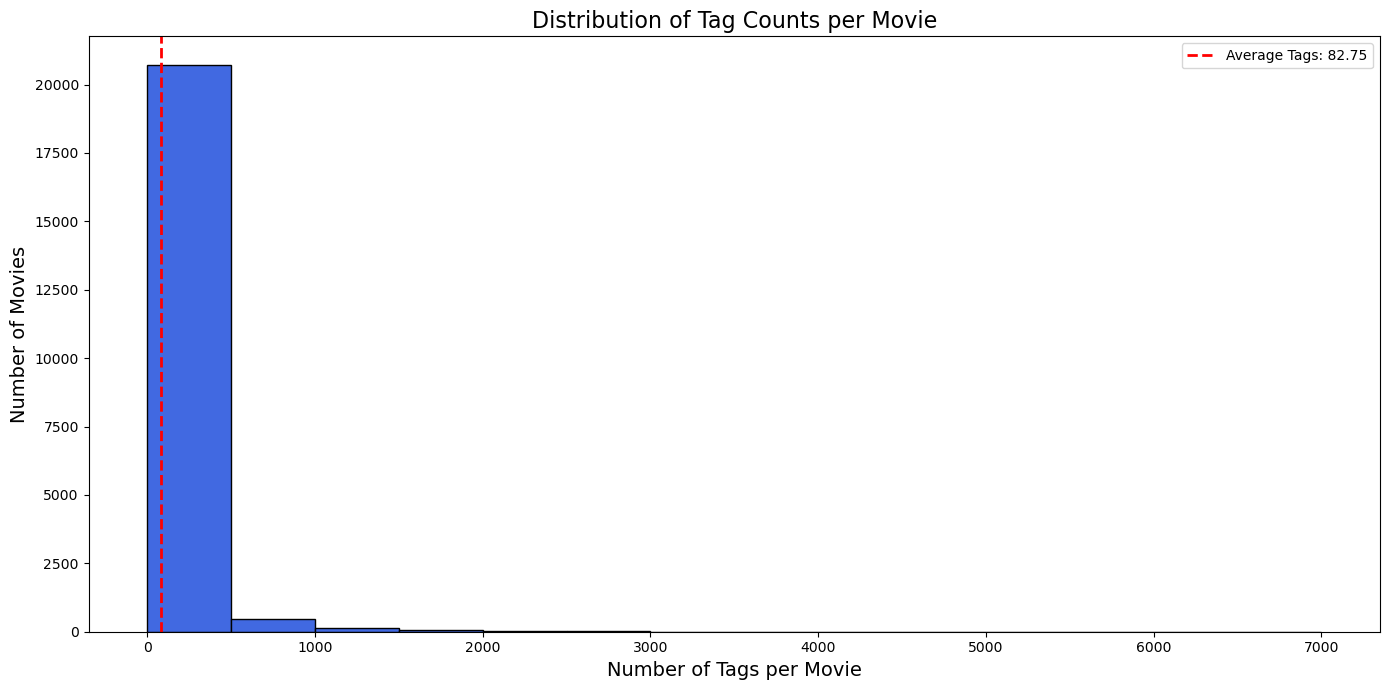

In [126]:
tag_counts = movie_tags['movie_id'].value_counts()
bin_size = 500
max_tags = tag_counts.max()
bins = list(range(0, max_tags + bin_size, bin_size))
average_tags = tag_counts.mean()

plt.figure(figsize=(14, 7))
plt.hist(tag_counts, bins=bins, color = "royalblue", edgecolor='black')
plt.axvline(x=average_tags, color='red', linestyle='--', linewidth=2, label=f'Average Tags: {average_tags:.2f}')

plt.xlabel('Number of Tags per Movie', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.title('Distribution of Tag Counts per Movie', fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()

Looking at this plot we see that almost all of the movies have less than 500 tags which is expected. And the average amount of tags per movies is around 80. The plot is again strongly rightly scewed.

## 04.Feature Engineering and Model Building

Now let's talk about a little more about the way our recommendation system will work. First we are going to do what is called Collaborative Filtering. Collaborative Filtering relies on the fact that users who have agreed in the past (rated items similarly) will agree in the future, and that a user will prefer items that similar users liked.
Types of Collaborative Filtering

	1.User-Based CF: Recommends items that similar users liked.
	2.Item-Based CF: Recommends items similar to those the user liked.
	3.Model-Based CF: Uses machine learning models to learn latent factors.

The first and most important step for CF is for us to create a pivot table. The columns will represent all the movies. And every row will be a different user.

In [127]:
#user_movie_matrix = ratings_filtered.pivot_table(index='user_id', columns='movie_id', values='rating')

If we try to pivot our current movie ratings table we will receive a table with 200,000 rows and 80,000 columns, we have to calculate over 16B cells. We don't have the computational power to calculate this table. So we are going to have to reduce the amount of these ratings. We will do so by stratifying the movie ratings dataset by the amount of ratings per user. We are going to divide the users in 3 categories - users with 20-49 ratings (less active users), users with 50-150 ratings (moderate activity users), 150+ ratings (active users).

In [128]:
user_counts = movie_ratings.groupby('user_id').size().reset_index(name='rating_count')

In [129]:
print(f" Users with less than 20 ratings - {user_counts[(user_counts.rating_count<20)].shape[0]}")
print(f" Users with less than 30 ratings - {user_counts[(user_counts.rating_count<30)].shape[0]}")
print(f" Users with ratings between 20 and 49 - {user_counts[(user_counts.rating_count>20) & (user_counts.rating_count<50)].shape[0]}")
print(f" Users with ratings between 50 and 150 - {user_counts[(user_counts.rating_count>49) & (user_counts.rating_count<151)].shape[0]}")
print(f" Users with ratings above 150 - {user_counts[(user_counts.rating_count>150)].shape[0]}")

 Users with less than 20 ratings - 934
 Users with less than 30 ratings - 35011
 Users with ratings between 20 and 49 - 67190
 Users with ratings between 50 and 150 - 72707
 Users with ratings above 150 - 54794


We are going to use 20-49 as our less active users criteria. Becuase the amount of users we have with ratings less than 20 are just 840. As well the amount of users with ratings less than 30 are 35000. These 800 users with ratings below 840 might introduce bias becuase of they are just 0.4% of all users.

In [130]:
user_counts = user_counts[user_counts['rating_count'] >= 20]
ratings_filtered = movie_ratings.merge(user_counts[['user_id']], on='user_id', how='inner')

In [131]:
user_counts = ratings_filtered.groupby('user_id').size().reset_index(name='rating_count')

def assign_activity(rating_count):
    """
    Categorizes the activity level of a movie based on its number of ratings.

    Parameters:
    - rating_count (int): The total number of ratings a movie has received.

    Returns:
    - str: The activity level category ('Less', 'Moderate', 'High').
    """

    if 20 <= rating_count <= 49:
        return 'Less' 
    elif 50 <= rating_count <= 150:
        return 'Moderate'  
    elif rating_count >= 151:
        return 'High'   

user_counts['activity'] = user_counts['rating_count'].apply(assign_activity)


print("User distribution based on user's amount of ratings:")
print(user_counts['activity'].value_counts())

User distribution based on user's amount of ratings:
activity
Moderate    72707
Less        72513
High        54794
Name: count, dtype: int64


We see that the these labels are relatively balanced. Now let's extract only some of those users and use only their ratings. We are going to take 40% of the current users and remove the rest.


In [132]:
movie_ratings = movie_ratings.merge(user_counts[['user_id', 'activity']], on='user_id', how='left')


In [133]:
users = user_counts[['user_id', 'activity']]
users_sampled, _ = sk_train_test_split(
    users,
    stratify=users['activity'],
    train_size=0.4,
    random_state=42
)

print("Sampled user distribution across strata:")
print(users_sampled['activity'].value_counts())

Sampled user distribution across strata:
activity
Moderate    29083
Less        29005
High        21917
Name: count, dtype: int64


We succefully removed a lot of users and as we can see the distribution of the activity label hasn't changes and is still balanced. There a little bit less users with high amount of ratings in comparisson to the other, but this won't be a problem because they have a lot more ratings than the rest.

In [134]:
ratings_sampled = movie_ratings[movie_ratings['user_id'].isin(users_sampled['user_id'])].reset_index(drop=True)
ratings_sampled = ratings_sampled.drop(columns=['activity','timestamp'])

In [135]:
ratings_sampled.sample(10)

,user_id,movie_id,rating
6004613,96766,252662,4.0
8697193,139786,1345,3.0
6855397,109835,43932,4.0
55271,914,1485,2.0
3806284,61315,97836,2.0
10585744,171060,178,4.0
2443406,39076,111659,3.5
238873,3921,8874,3.0
1811575,28730,1388,2.0
10295836,166298,87232,4.0


In [136]:
user_counts = ratings_sampled['user_id'].value_counts()
ratings_filtered = ratings_sampled[ratings_sampled['user_id'].isin(user_counts.index)]

movie_counts = ratings_filtered['movie_id'].value_counts()
ratings_filtered = ratings_filtered[ratings_filtered['movie_id'].isin(movie_counts.index)]

num_users = ratings_filtered['user_id'].nunique()
num_movies = ratings_filtered['movie_id'].nunique()
print(f"Number of users: {num_users}, Number of movies: {num_movies}")


Number of users: 80005, Number of movies: 22852


So finally for training our model we will use 80000 users and 22000 movies.

We have to choose which type of CF we are going to use for recommendation system. Due to the large amount of data that we currently have we are goint to choose the model-based one, using dimensionality reduction tequnices so we can manage all of this data. The method that we are going to use is matrix factorization - SVD. It is perfect for our current situation because it would allow us to work with this big sparse matrix, by dividing it into two much smaller matrixes - one for the users and one for the movies. So it is going to be more easier to work with them. We will choose SVD instead of SVD++, which can capture implicit information about the user as well (if the user interacted with a particular movie, no matter the rating). The reason for choosing SVD is due the computanial power needed to calculate SVD++ and as we will see below there won't be much of a difference between the models results.

For using SVD we are going to import Surpise library. It is a Python scikit for building and analyzing recommender systems. It offers various ready-to-use algorithms and is optimized for performance.

First we have to convert our dataset to a vaiable to a readable for Surpise format. We are going to create a reader with the rating scale set from 1 to 5. And then we are going to use our sampled rating with this reader to create our new dataset.

In [137]:
reader = Reader(rating_scale=(ratings_sampled['rating'].min(), ratings_sampled['rating'].max()))
data = Dataset.load_from_df(ratings_sampled[['user_id', 'movie_id', 'rating']], reader)

Now we are going to import Pickle library, which enables easier serialization and deserialization of Python objects. We will use it for saving our current models, predictions and some datasets, so we won't have to train them every time we run the notebook.

In [138]:
TRAINSET_PATH = "cf_trainset.pkl"
TESTSET_PATH = "cf_testset.pkl"
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(obj, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)

if os.path.exists(TRAINSET_PATH) and os.path.exists(TESTSET_PATH):
    print("Loading existing train-test splits from pickle files...")
    cf_trainset = load_pickle(TRAINSET_PATH)
    cf_testset = load_pickle(TESTSET_PATH)
else:

    cf_trainset, cf_testset = sp_train_test_split(data, test_size=0.2, random_state=42)
    save_pickle(cf_trainset, TRAINSET_PATH)
    save_pickle(cf_testset, TESTSET_PATH)


Loading existing train-test splits from pickle files...


First we are going to test one of the simplest predictors - Normal Predictor, which uses Gaussian distribution for its ratings.

The metrics that we are going to use for our rating predictor are RMSE(Root Mean Squared Error) and MAE(Mean Absoulute Error). Where RMSE is the average value of the squared differences between predicted and actual values, so it is more prone to outliers. And MAE measures the average of the absolute differences between the predicted and actual values.


$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$

$MAE = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$



In [139]:
def save_model(model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)

def load_model(filepath):
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    return model

In [140]:
MODEL_PATH = "normal_default_model"  
if os.path.exists(MODEL_PATH):
    normal_predictor = load_model(MODEL_PATH)
else:
    normal_predictor = NormalPredictor()
    normal_predictor.fit(cf_trainset)
    save_model(normal_predictor, MODEL_PATH)

PREDICTIONS_NORMAL_PATH = "normal_predictions.pkl"
if os.path.exists(PREDICTIONS_NORMAL_PATH):
    predictions= load_pickle(PREDICTIONS_NORMAL_PATH)
else:
    predictions = normal_predictor.test(cf_testset)
    save_pickle(predictions, PREDICTIONS_NORMAL_PATH)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.4419
MAE:  1.1481


In [141]:
max_rating = 5
min_rating = 1
rmse_percentage = (rmse/(max_rating-min_rating))*100
mae_percentage = (mae/(max_rating-min_rating))*100
print("Error Percentages: ")
print(f"RMSE% - {rmse_percentage:0.2f}%")
print(f"MAE% - {mae_percentage:0.2f}%")

Error Percentages: 
RMSE% - 36.05%
MAE% - 28.70%


Here having both of these error metrics above 1.1 can be considered pretty bad, having in mind that we work with a scale from 1 to 5. This means that on average the predicited ratings are off than more than 1. In percentage as we saw these errors translate to around 32% of error.

Let's start by trying SVD with its defaul parameters and see the result.

In [142]:
MODEL_PATH = "svd_default_model"  
if os.path.exists(MODEL_PATH):
    svd = load_model(MODEL_PATH)
else:
    svd = SVD()
    svd.fit(cf_trainset)
    save_model(svd, MODEL_PATH)

In [143]:
PREDICTIONS_SVD_PATH = "svd_default_predictions.pkl"
if os.path.exists(PREDICTIONS_SVD_PATH):
    predictions_svd = load_pickle(PREDICTIONS_SVD_PATH)
else:
    predictions_svd = svd.test(cf_testset)
    save_pickle(predictions_svd, PREDICTIONS_SVD_PATH)
    
rmse_svd_default = accuracy.rmse(predictions_svd)
mae_svd_default = accuracy.mae(predictions_svd)


RMSE: 0.7299
MAE:  0.5503


In [144]:
rmse_percentage = (rmse_svd_default/(max_rating-min_rating))*100
mae_percentage = (mae_svd_default/(max_rating-min_rating))*100
print("Error Percentages: ")
print(f"RMSE% - {rmse_percentage:0.2f}%")
print(f"MAE% - {mae_percentage:0.2f}%")

Error Percentages: 
RMSE% - 18.25%
MAE% - 13.76%


As we can see already the RMSE and MAE are significantly better than the metrics from the Normal Predictor. We have RMSE of 0.77 and MAE of around 0.59 which can be considered good for a movie recommendations. But now let's try and optimize this model further by adjusting its hyperparameters.

For this task we are going to import the Hyperopt library which is designed for efficent hyperparameter optimization. By defining our hyperparameters search space beforehand this library uses Tree-structured Parzen Estimator (TPE) to make informed decisions about where to search next and not to go through every possible combination like popular algorithms such as Grid Search do. 

In [145]:
MODEL_PATH = "svd_best_model"  
if os.path.exists(MODEL_PATH):
    svd_best = load_model(MODEL_PATH)   
else:
    def objective(params):
        # Function for Hyperopt to optimize
        n_factors = int(params['n_factors'])
        n_epochs = int(params['n_epochs'])
        lr_all = params['lr_all']
        reg_all = params['reg_all']

        print(f"Training with parameters:")
        print(f"n_factors={n_factors}, n_epochs={n_epochs}, lr_all={lr_all:.5f}, reg_all={reg_all:.5f}")

        svd = SVD(
            n_factors=n_factors,
            n_epochs=n_epochs,
            lr_all=lr_all,
            reg_all=reg_all,
            random_state=42,
            verbose=False
        )
        svd.fit(cf_trainset)

        predictions = svd.test(cf_testset)

        rmse = accuracy.rmse(predictions, verbose=False)

        return {'loss': rmse, 'status': STATUS_OK}

    #search space
    space = {
        'n_factors': hp.quniform('n_factors', 50, 200, 10),
        'n_epochs': hp.quniform('n_epochs', 20, 60, 5),
        'lr_all': hp.loguniform('lr_all', -5, -2),
        'reg_all': hp.loguniform('reg_all', -5, -2)
    }
    #Here a history of all hyperparameters evaluations will be recorded
    trials = Trials()

    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=40,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    best_params = {
        'n_factors': int(best['n_factors']),
        'n_epochs': int(best['n_epochs']),
        'lr_all': best['lr_all'],
        'reg_all': best['reg_all']
    }

    print(" Best hyperparameters: ")
    print(best_params)

    svd_best = SVD(
        n_factors=best_params['n_factors'],
        n_epochs=best_params['n_epochs'],
        lr_all=best_params['lr_all'],
        reg_all=best_params['reg_all'],
        random_state=42,
        verbose=True  
    )
    svd_best.fit(cf_trainset)
    save_model(svd_best, MODEL_PATH)

In [146]:
PREDICTIONS_SVD_BEST_PATH = "svd_best_predictions.pkl"
if os.path.exists(PREDICTIONS_SVD_BEST_PATH):
    predictions_svd_best= load_pickle(PREDICTIONS_SVD_BEST_PATH)
else:
    predictions_svd_best = svd_best.test(cf_testset)
    save_pickle(predictions_svd_best, PREDICTIONS_SVD_BEST_PATH)
    
rmse_svd_best = accuracy.rmse(predictions_svd_best)
mae_svd_best = accuracy.mae(predictions_svd_best)

RMSE: 0.6961
MAE:  0.5227


As we see we have managed to imporve our metrics from the base SVD even further. As the final result being RMSE - 0.62 and MAE - 0.47, which is now decent enough to use for our movie recommendations.

Now let's test the default SVD++ just for comparisson.

In [147]:
MODEL_PATH = "svdpp_default_model"  
if os.path.exists(MODEL_PATH):
    svdpp = load_model(MODEL_PATH)
else:
    svdpp = SVDpp()
    svdpp.fit(cf_trainset)
    save_model(svdpp, MODEL_PATH)

In [148]:
PREDICTIONS_SVDpp_PATH = "svdpp_default_predictions.pkl"
if os.path.exists(PREDICTIONS_SVDpp_PATH):
    predictions_svdpp = load_pickle(PREDICTIONS_SVDpp_PATH)
else:
    predictions_svdpp = svdpp.test(cf_testset)
    save_pickle(predictions_svdpp, PREDICTIONS_SVDpp_PATH)
    
rmse_svdpp_default = accuracy.rmse(predictions_svdpp)
mae_svdpp_default = accuracy.mae(predictions_svdpp)

RMSE: 0.7771
MAE:  0.5857


As we can see the default SVD++ doesn't give us better results than the normal SVD. This doesn't mean that it is worse, but due the time it takes for training this model we are going to use SVD.

Below is the hyperparameter tuning for the SVD++, which we won't run for now due to the amount of resources needed.

In [149]:
MODEL_PATH = "svdpp_best_model"

def svdpp_model():
    """Hyperparameter tuning for SVDpp"""
    
    if os.path.exists(MODEL_PATH):
        svdpp_best = load_model(MODEL_PATH)   
    else:
        def objective(params):
            n_factors = int(params['n_factors'])
            n_epochs = int(params['n_epochs'])
            lr_all = params['lr_all']
            reg_all = params['reg_all']

            print(f"Training with parameters:")
            print(f"n_factors={n_factors}, n_epochs={n_epochs}, lr_all={lr_all:.5f}, reg_all={reg_all:.5f}")

            svdpp = SVDpp(
                n_factors=n_factors,
                n_epochs=n_epochs,
                lr_all=lr_all,
                reg_all=reg_all,
                random_state=42,
                verbose=False
            )
            svdpp.fit(cf_trainset)

            predictions = svdpp.test(cf_testset)

            rmse = accuracy.rmse(predictions, verbose=False)

            return {'loss': rmse, 'status': STATUS_OK}

        space = {
            'n_factors': hp.quniform('n_factors', 20, 100, 10),
            'n_epochs': hp.quniform('n_epochs', 5, 30, 5),
            'lr_all': hp.loguniform('lr_all', np.log(0.0001), np.log(0.1)),
            'reg_all': hp.loguniform('reg_all', np.log(0.0001), np.log(0.1))
        }

        trials = Trials()

        best = fmin(
            fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials,
            rstate=np.random.default_rng(42)
        )

        best_params = {
            'n_factors': int(best['n_factors']),
            'n_epochs': int(best['n_epochs']),
            'lr_all': best['lr_all'],
            'reg_all': best['reg_all']
        }

        print(" Best hyperparameters: ")
        print(best_params)

        svdpp_best = SVDpp(
            n_factors=best_params['n_factors'],
            n_epochs=best_params['n_epochs'],
            lr_all=best_params['lr_all'],
            reg_all=best_params['reg_all'],
            random_state=42,
            verbose=True  
        )
        svdpp_best.fit(cf_trainset)
        save_model(svdpp_best, MODEL_PATH)
        
    return svdpp_best


In [150]:
error_data = {
    'Model': ['SVD_Default','SVD_best','SVD++', 'NormalPredictor'],
    'RMSE': [rmse_svd_default,rmse_svd_best, rmse_svdpp_default, rmse],
    'MAE': [mae_svd_default,mae_svd_best, mae_svdpp_default, mae]
}

error_df = pd.DataFrame(error_data)

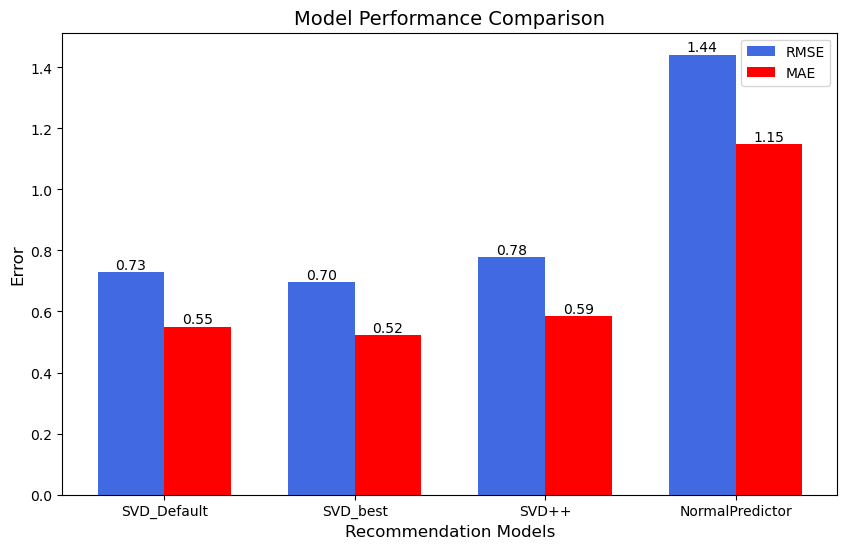

In [151]:
models = error_data['Model']
rmse = error_data['RMSE']
mae = error_data['MAE']

x = np.arange(len(models))
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, rmse, width, label='RMSE', color='royalblue')
ax.bar(x + width/2, mae, width, label='MAE', color='red')


ax.set_xlabel('Recommendation Models', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for i in range(len(models)):
    ax.text(x[i] - width/2, rmse[i] + 0.01, f'{rmse[i]:.2f}', ha='center', fontsize=10)
    ax.text(x[i] + width/2, mae[i] + 0.01, f'{mae[i]:.2f}', ha='center', fontsize=10)



plt.show()

As we can see from the plot, there isn’t much difference between the default SVD and the one with optimized hyperparameters, but we will proceed with the more optimized version. With a final result of an RMSE of 0.7 and an MAE of 0.52, the performance is quite decent for our rating scale. Therefore, we can move forward with using this model.

Now the problem that we can have with just Collaborative Filtering is the problem with new users and new movies. Either the users don’t have previous ratings, or the movie has just been released and it doesn’t have ratings as well.

To solve that problem, let’s introduce CBF (Content-Based Filtering). Unlike CF, which relies on the interactions between the user and the movie, this method focuses more on the similarity between the different users and movies separately. Let’s look at a simple example for CBF. Let’s say User_20 likes movie X, which has genres Drama and Action. Now, using techniques for extracting similarities between items, we can suggest this User_20 a movie with the same genres. Using this approach, we remove the problem with the cold start because we can recommend new movies just by knowing their features.

In [152]:
movies_tmdb = movies_tmdb.reset_index(drop=True)

In [153]:
movies_tmdb.dtypes

title                        object
vote_average                float64
vote_count                  float64
release_date         datetime64[ns]
runtime                     float64
imdb_id                       int64
original_language            object
overview                     object
popularity                  float64
genres                       object
spoken_languages             object
cast                         object
director                     object
writers                      object
imdb_rating                 float64
imdb_votes                  float64
dtype: object

First let's take the movie_tags dataset and add all of those tags as features in our movie metadata dataset, so we can use it for our CBF. First we are going to merge them with the links dataset so we can marge the tags with the Movies TMDB dataset easier.

In [154]:
tags_with_imdb = movie_tags.merge(movie_links[['movie_id', 'imdb_id']], on='movie_id', how='left')
tags_agg = tags_with_imdb.groupby('imdb_id')['tag'].apply(list).reset_index()

movies = movies_tmdb.merge(
    tags_agg,
    on='imdb_id',
    how='left'
)
#movies['tag'] = movies['tag'].apply(lambda x: ' '.join(x))


We cannot directly return them as a string becuase there are some movies with a contain a nan value in tags. So we have to remove those ones first.

In [155]:
movies['tag'] = movies['tag'].apply(lambda x: [item for item in x if pd.notnull(item)] if isinstance(x, list) else [])
movies['tag'] = movies['tag'].apply(lambda x: ' '.join(x))

In [156]:
movies["tag"]

0        multiple storylines Tim Roth Tumey's VHS 4 Ant...
1        boxing match chicago drug dealer escape one ni...
2        sci-fi space epic adventure Intergalactic acti...
3        children Pixar predictable too cute animals an...
4        bittersweet comedy drama emotional great actin...
                               ...                        
22848    bank robbery bonding crime syndicate gunfight ...
22849         child abuse child molestation child molester
22850                                  Interesting concept
22851                         cyberpunk Ghost in the Shell
22852                                                     
Name: tag, Length: 22853, dtype: object

Now, for our non-numerical features, we are going to combine them into one big string and then use the TF-IDF vectorizer to convert them into numerical features, on which we can calculate the similarity later on.

Now, we need to clean and transform this new feature. To do so, we are going to use the NLTK library. Firstly, we will convert all the text to lowercase so that it is consistent and there won’t be a difference between “man” and “Man.” After that, we will remove commonly used English words that don’t add much value, such as “the,” “a,” etc.

For some of the features, we are going to apply additional preprocessing and apply stemming. This is a text processing technique that reduces words to their base or root form by removing prefixes and suffixes. We are going to use it for tags and overview as they tend to have a lot of words in different forms, which we should count as the same word. For the stemming, we are just going to use one of the most popular stemmers — Snowball Stemmer.

For genres, original languages, and spoken languages, there is no need to remove any stop words or stem them. This is because we already know from our analysis the number of different values we have for them, and they are already normalized to have the same format for every movie.

We have to convert every one of these features to a string and then combine them into one.


In [157]:
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def preprocess_with_stemming(text):
    """
    Preprocesses text by lowercasing, tokenizing, removing stop words and non-alphabetic tokens,
    and applying stemming.
    """
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

def preprocess_without_stemming(text):
    """
    Preprocesses text by lowercasing, tokenizing, and removing stop words and non-alphabetic tokens.
    Does not apply stemming.
    """
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(tokens)

#Convert from list to string
genres = movies['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
spoken_languages = movies['spoken_languages'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

#Remove stopwords and stem
tag_processed = movies['tag'].apply(lambda x: preprocess_with_stemming(x) if isinstance(x, str) else '')
overview_processed = movies['overview'].apply(lambda x: preprocess_with_stemming(x) if isinstance(x, str) else '')

#remove stop words and lower
cast_processed = movies['cast'].apply(lambda x: preprocess_without_stemming(x) if isinstance(x, str) else '')
director_processed = movies['director'].apply(lambda x: preprocess_without_stemming(x) if isinstance(x, str) else '')
wrtiers_processed = movies['writers'].apply(lambda x: preprocess_without_stemming(x) if isinstance(x, str) else '')

categorical_feature = genres + " "+ tag_processed + " " + overview_processed + " " + cast_processed + " " + director_processed + " " +  spoken_languages

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/stefantabakov/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefantabakov/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now let's calcuate our TF-IDF matrix with this feature.

In [158]:
vectorizer = TfidfVectorizer(stop_words="english",max_features=200000,ngram_range=(1,2))
feature_vectors = vectorizer.fit_transform(categorical_feature)

For the original language, we are going to use One-Hot Encoding because every movie has exactly one original language, and we have previously reduced the number of original languages to 10. So, it is not necessary to add them in the TF-IDF matrix. For example, languages like English might be really important, but due to the fact that TF-IDF calculates frequencies, and almost all of the movies have English as an original language, it will have lower weight because of that. For that purpose, we are going to use OneHotEncoder from sklearn, which will return us a sparse matrix.

In [159]:
ohe = OneHotEncoder(handle_unknown='ignore')
language_encoded = ohe.fit_transform(movies[['original_language']])

Now let’s transform our numerical features. First, we need to convert release_date to a numerical representation. We are going to convert it to how many years the movie has been released. We will do so by extracting the year of the release date and subtracting it from the current year.

In [160]:
movies['release_year'] = movies['release_date'].dt.year
current_year = datetime.now().year
movies['movie_age'] = current_year - movies['release_year']
movies.drop(columns=['release_date', 'release_year'], inplace=True)

After that we are going to use two scalers for our numerical features. First we are going to apply Robust Scaler, because it will minimize the impact of the outliers we have. Then we are going to transfer it into interval of 0-1 so it can have the same weight as the other features when calculating the similarity score.

For numerical features we are only going to use movie age, popularity and imdb rating. We won't use the number of votes per movie because it is tightly connected with the popularity feature. And there is no need to include the tmdb rating as well, because it is higly correlated with the imdb rating as we saw above.

In [161]:
numerical_features = movies[['movie_age','popularity','imdb_rating' ]]

pipeline = make_pipeline(
    RobustScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

numerical_scaled = pipeline.fit_transform(numerical_features)

We will use csr_matrix to make the Original Languages and Numerical Features into the right format (sparse matrix). And then hstack to merge these matrices with the TF-IDF one and then compute the similarity for the whole matrix.

In [162]:
language_encoded_sparse = csr_matrix(language_encoded)
numerical_scaled_sparse = csr_matrix(numerical_scaled)

combined_features = hstack([
    feature_vectors,
    language_encoded_sparse,
    numerical_scaled_sparse
])
feature_vectors.shape

(22853, 200000)

For calculating the similarities between movies, we are going to use the Cosine Similarity score. We will use cosine similarity because it is irrespective of the size of the vectors. It only calculates the angle between them, how close they are, and their length doesn’t matter. The values of the cosine similarities vary from -1 to 1. Where 1 is when the vectors are identical in direction, 0 is when they are orthogonal, so there is no similarity, and -1 is when the vectors are exactly in opposite directions, so they have maximum dissimilarity.

$Cosine Similarity = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}$

We calculate the dot product of two vectors and then divide it by the multiplications of their second norms.

In [163]:
similarity = cosine_similarity(combined_features)
similarity.shape

(22853, 22853)

Let’s now try our system with the movies that we have left. We are going to make the user input a movie title and then, using difflib, get the closest match to the user input from the movie titles in our dataset. After that, we will sort the similarities for this particular movie and print the top 10 most similar movies.

## 05.Movie Recommendation

For the first, simpler movie recommendation, we are going to show the most similar movies based solely on the similarities between them from the CBF.

In [164]:
def recommend_top_simmilar_movies(movie_name, number_of_recommendations = 10):
  """
    Recommend top similar movies based on the provided movie name, using cosine similarity.

    Parameters:
    - movie_name (str): The title of the movie to find similar recommendations for.
    - number_of_recommendations (int): The number of top similar movies to recommend. Default is 10.

    Returns:
    - None: Prints the list of recommended movie titles.
    """
  list_of_all_titles = movies_tmdb['title'].tolist()

  find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
  close_match = find_close_match[0]

  index_of_the_movie = movies_tmdb[movies_tmdb.title == close_match].index.values[0]
  title_of_the_movie = movies_tmdb[movies_tmdb.title == close_match]['title'].values[0]

  similarity_score = list(enumerate(similarity[index_of_the_movie]))

  sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True) 

  print('Movies suggested for you : \n')

  i = 1
  for movie in sorted_similar_movies:
    index = movie[0]
    title_from_index = movies_tmdb[movies_tmdb.index==index]['title'].values[0]
    if title_from_index != title_of_the_movie:
            if i <= number_of_recommendations:
                print(i, '.', title_from_index)
                i += 1
    if i > number_of_recommendations:
        break


movie_name = input('Enter your favourite movie name : ')
recommend_top_simmilar_movies(movie_name)

Movies suggested for you : 

1 . Iron Man 2
2 . Iron Man 3
3 . The Avengers
4 . Avengers: Age of Ultron
5 . Avengers: Endgame
6 . Avengers: Infinity War
7 . Captain America: Civil War
8 . Ant-Man
9 . X-Men
10 . Spider-Man 2


For now these movie recommendations are pretty decent. Let's now have add the Collaborative Filtering in the equation. We are going to do so by updating this function so you can enter an id of a curent user. And it will give recommendations both on the predicted ratings and the CBF results. And it will not recommend movies that the user has alreay watched.

Let's add movie_id in movies just for easier movie access.

In [165]:
movies = movies.merge(movie_links[['movie_id', 'imdb_id']], on='imdb_id', how='left')

In [166]:
def is_new_user(user_id, movie_ratings):
    """Function that checks if a user with this id exists."""
    return user_id not in movie_ratings['user_id'].unique()

Now let's build a function that uses both CF and CBF. It will do so by firstly creating a dataset with the scores of the cosine similarity metric. Which will only have the movie_id and similarity score. We will normalize the similarity score to be from -1,1 to 0,1. Then after that we will check if the movies that the specific user has already rated and remove them from our recommendation table. We will calculate the predicted ratings and again we are going to normalize them to be between 0 and 1.

In [167]:
def get_combined_recommendations(user_id, sorted_similar_movies, top_n=10):
    """
    Combines Content-Based Filtering (CBF) and Collaborative Filtering (CF) to generate
    a ranked list of movie recommendations for a user.

    Parameters:
    - user_id (int): The identifier of the user for whom recommendations are being generated.
    - sorted_similar_movies (list of tuples): A list containing tuples of movie indices and their similarity scores
      relative to a reference movie.
    - top_n (int): The number of top recommendations to return. Default is 10.

    Returns:
    - list: A list of movie titles recommended for the user.

    """
  
    cb_movie_indices = [movie[0] for movie in sorted_similar_movies]
    cb_similarity_scores = [movie[1] for movie in sorted_similar_movies]
    
    cb_recommendations = pd.DataFrame({
        'movie_id': movies.loc[cb_movie_indices, 'movie_id'].values,
        'similarity_score': cb_similarity_scores
    })
    
    #We will normalize the scores of the Content-Based Filtering.
    cb_recommendations['normalized_similarity_score'] = (
        cb_recommendations['similarity_score'] - cb_recommendations['similarity_score'].min()
    ) / (cb_recommendations['similarity_score'].max() - cb_recommendations['similarity_score'].min())
    


    # Predict ratings using CF model and removing already ratied movies.
    candidate_movie_ids = cb_recommendations['movie_id'].tolist()
    
    
    user_rated_movies = movies[movie_ratings['user_id'] == user_id]['movie_id'].tolist()
    candidate_movie_ids = [mid for mid in candidate_movie_ids if mid not in user_rated_movies]
    
    predictions = []
    for movie_id in candidate_movie_ids:
        pred = svd_best.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))
    
   
    cf_predictions_df = pd.DataFrame(predictions, columns=['movie_id', 'predicted_rating'])
    
    # Normalize predicted ratings
    cf_predictions_df['normalized_predicted_rating'] = (
        cf_predictions_df['predicted_rating'] - cf_predictions_df['predicted_rating'].min()
    ) / (cf_predictions_df['predicted_rating'].max() - cf_predictions_df['predicted_rating'].min())
    

    combined_df = cb_recommendations.merge(cf_predictions_df, on='movie_id', how='inner')
    
  
    weight_cb = 0.7
    weight_cf = 0.3
    combined_df['combined_score'] = (
        weight_cb * combined_df['normalized_similarity_score'] +
        weight_cf * combined_df['normalized_predicted_rating']
    )

    combined_df = combined_df.sort_values('combined_score', ascending=False)

    top_recommendations = combined_df.head(top_n)
    

    recommended_movies = movies[movies['movie_id'].isin(top_recommendations['movie_id'])]
    recommended_movies = recommended_movies[['title']]
    

    return recommended_movies['title'].tolist()

The following function will accept both User ID and a movie name. If the user ID is not valid, it will notify the user and recommend movies only based on the CBF. If the user ID is correct, it will call the function above, which will return recommendations for movies that the user has not previously watched. It will work like this: User X wants to watch a movie similar to movie Y. The function will calculate the score for the similar movies and also predict the movies that User X will rate the highest. Then, it will combine both these results to give the final answer. We are going to put more weight on the similarity scores so the movies are more similar to movie Y. The final result will be the combination of both these answers, and the movies will be returned sorted based on this combined feature.

In [168]:
def get_hybrid_recommendations(user_id, movie_name, top_n=10):
    """
    Generates a set of movie recommendations for a user by integrating both Content-Based Filtering (CBF)
    and Collaborative Filtering (CF). It first identifies movies similar to a given reference movie and
    then combines these with user-specific collaborative predictions, if the user_id is valid. Returns
    only results from CBF for an invalid user.

    Parameters:
    - user_id (int): The identifier of the user for whom recommendations are being generated.
    - movie_name (str): The title of the reference movie to find similar movies.
    - top_n (int): The number of top recommendations to return. Default is 10.

    Returns:
    - list: A list of recommended movie titles based on the hybrid approach.
    """
    list_of_all_titles = movies['title'].tolist()
    find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
    
    if not find_close_match:
        print("No close match found for the movie name provided.")
        return
    
    close_match = find_close_match[0]
    index_of_the_movie = movies[movies.title == close_match].index.values[0]
    
   
    similarity_score = list(enumerate(similarity[index_of_the_movie]))
    sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    if is_new_user(user_id, movie_ratings):
        print("New user detected. Using content-based recommendations only.")
        recommended_movies = []
        i = 0
        for movie in sorted_similar_movies:
            index = movie[0]
            title_from_index = movies.loc[index, 'title']
            if i < top_n:
                recommended_movies.append(title_from_index)
                i += 1
        return recommended_movies
    
    else:
        return get_combined_recommendations(user_id, sorted_similar_movies, top_n)

In [169]:
user_id = int(input('Enter your user ID: '))
movie_name = input('Enter your favourite movie name: ')

recommendations = get_hybrid_recommendations(user_id, movie_name, top_n=10)

if recommendations:
    print('\nMovies suggested for you:\n')
    for idx, title in enumerate(recommendations, start=1):
        print(f"{idx}. {title}")
else:
    print("No recommendations available.")


Movies suggested for you:

1. Iron Man
2. Captain America: The First Avenger
3. Iron Man 2
4. The Avengers
5. Iron Man 3
6. Avengers: Age of Ultron
7. Ant-Man
8. Captain America: Civil War
9. Avengers: Endgame
10. Avengers: Infinity War


/var/folders/6f/pgdvkqt91lq31wb_lcq5cwr80000gn/T/ipykernel_20969/3284985181.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_rated_movies = movies[movie_ratings['user_id'] == user_id]['movie_id'].tolist()


In this project, we aimed to develop a comprehensive recommendation system by integrating both Collaborative Filtering (CF) and Content-Based Filtering (CBF) techniques. Our objective was to enhance the accuracy and personalization of recommendations by leveraging the strengths of each approach. By utilizing models (matrix factorization techniques) such as SVD, SVD++, and incorporating content-based methodologies, we sought to create a robust system capable of effectively predicting user preferences.

Through extensive experimentation and evaluation, we discovered that the hybrid models, particularly SVD combined with content-based feature can outperformed traditional methodologies like basic CF with no data preproccessing. This improvement underscores the value of incorporating additional user and item metadata alongside interaction data, enabling the system to capture more nuanced patterns in user behavior.

Looking ahead, there are several avenues for future work. Incorporating even more advanced hybrid models and integrating deep learning approaches like Neural Collaborative Filtering (NeuralCF) could potentially yield even greater improvements in recommendation performance. Additionally, expanding the dataset and incorporating real-time user feedback would allow for more dynamic and responsive recommendations. Overall, this project successfully demonstrated the benefits of combining Collaborative and Content-Based Filtering, laying a solid foundation for further advancements in building personalized and accurate recommendation systems.

## References
https://deepnote.com/app/jayjburgess/Find-Movie-Similarity-from-Plot-Summaries-2407ab30-36ba-4506-a9c8-54ba62fe48d6

https://labelyourdata.com/articles/movie-recommendation-with-machine-learning

https://research.ijcaonline.org/volume110/number4/pxc3900760.pdf